<a href="https://colab.research.google.com/github/jofmorenore/TS_Climatic/blob/main/R/SeasonalDFM_PrecipitationAirports6C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://stackoverflow.com/questions/74283327/conversion-py2rpy-not-defined-for-objects-of-type-class-str
!pip install rpy2==3.5.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp312-cp312-linux_x86_64.whl size=316572 sha256=13f4a848637c452c61c44e3556dd4d8b93bacbcaf8ef5afb1ecbdf1c3109ca97
  Stored in directory: /root/.cache/pip/wheels/00/26/d5/d5e8c0b039915e785be870270e4a9263e5058168a03513d8cc
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.17
    Uninstalling rpy2-3.5.17:
      Successfully uninstalled rpy2-3.5.17


In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
getwd()

[1] "/content"


In [4]:

%%R
sessionInfo()

R version 4.5.2 (2025-10-31)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 22.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3;  LAPACK version 3.10.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

loaded via a namespace (and not attached):
[1] compiler_4.5.2


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%%R
if("astsa" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("astsa"))}
library(astsa)







	‘/tmp/Rtmp3SQig1/downloaded_packages’



In [7]:
%%R
if("forecast" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("forecast"))}
library(forecast)















	‘/tmp/Rtmp3SQig1/downloaded_packages’

  method            from
  as.zoo.data.frame zoo 

Attaching package: ‘forecast’



    gas




In [9]:
%%R
#if("geobr" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("geobr"))}
#library(geobr)

NULL


In [8]:
%%R
if("ggspatial" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("ggspatial"))}
library(ggspatial)














	‘/tmp/Rtmp3SQig1/downloaded_packages’



In [81]:
%%R
if("tsoutliers" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("tsoutliers"))}
library(tsoutliers)







	‘/tmp/Rtmp3SQig1/downloaded_packages’



In [109]:
%%R
if("aTSA" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("aTSA"))}
library(aTSA)







	‘/tmp/Rtmp3SQig1/downloaded_packages’

Attaching package: ‘aTSA’



    adf.test, kpss.test, pp.test



    forecast



    identify




In [167]:
%%R
if("greybox" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("greybox"))}
library(greybox)







	‘/tmp/Rtmp3SQig1/downloaded_packages’



Attaching package: ‘greybox’



    forecast



    hm



    spread




In [168]:
%%R
library(tidyverse)
library(astsa)
library(forecast)
#library(geobr)
library(ggspatial)
library(urca)
library(readxl)
library(sf)
library(ggplot2)
library(tsoutliers)
library(tseries)
library(aTSA)
library(greybox)
#library(maps)
#library(sp)
#library(units) # convertir a km
#library(forcats)

In [10]:
%%R
LamYaotest <- function (X, k0, kmax){
  N <- dim(X)[1]
  P <- dim(X)[2]

  if(missing(kmax)) kmax <- round(P/2,digits = 0)

  if (k0==1){
    dW=cov(X[2:N,], X[1:(N-1),])
    Wy=dW%*%t(dW)
    eA=eigen(Wy, symmetric=T)
    ev=sort(eA$values, decreasing = TRUE)
  } else {
    dW=cov(X[2:N,], X[1:(N-1),])
    Wy=dW%*%t(dW)
    for(k in 2:k0) { dW=cov(X[(k+1):N,], X[1:(N-k),])
    Wy=Wy + dW%*%t(dW)
    }
    eA=eigen(Wy, symmetric=T)
    ev=sort(eA$values, decreasing = TRUE)
  }
  ratio <- rep(0,kmax)
  for (j in 1:kmax){
    ratio[j] <- ev[j]/ev[(j+1)]
  }
  r1 = which.max(ratio)

  results <- list(r1=r1, ratio=ratio, Wy=Wy)
  return(results)
}

In [11]:
%%R
CaroPenatest <- function (X, k0, kmax){
  N <- dim(X)[1]
  P <- dim(X)[2]

  if(missing(kmax)) kmax <- round(P/2,digits = 0)

  wk0 = N/((k0+1)*(N-(k0/2)))
  Wy = wk0 * cor(X) %*%t (cor(X))
  dW = acf(X, lag.max = k0, type = "correlation", plot = FALSE)

  for(k in 1:k0) {
    dWk = dW$acf[(k+1),,]
    wk = (N-k)/((k0+1)*(N-(k0/2)))
    Wy = Wy + wk * dWk %*% t(dWk)
  }
  eA=eigen(Wy, symmetric=T)
  ev=sort(eA$values, decreasing = TRUE)

  ratio <- rep(0,kmax)
  for (j in 1:kmax){
    ratio[j] <- ev[j]/ev[(j+1)]
  }
  r1 = which.max(ratio)
  results <- list(r1=r1, ratio=ratio, Wy=Wy)
  return(results)
}

In [44]:
%%R
"sarimaSpec" <- function(zt, maxorder = c(2,1,3), maxsea = c(1,1,1), criterion = "bic",
                         period = 12, output = FALSE,  method = "CSS-ML", include.mean = TRUE){

  if(is.matrix(zt))zt <- zt[,1]
  nn <- s.adftest(zt,period=period,lags=max(floor(period/2)-1,maxorder[1]))
  D <- d <- 0
  if(nn[1] >= -3.43)D <- 1
  if(nn[2] >= -3.43)d <- 1

  if((d==1) && (D==0)){
    tmp <- diff(zt)
    tst <- adftest(tmp,lags=(period+maxorder[1]-1))
    if(tst >= -3.43) d <- 2
  }

  choice <- c(0,d,0,0,D,0)
  dz <- zt
  if(d > 0){
    for (i in 1:d){
      dz <- diff(dz)
    }
  }
  if(D == 1)dz=diff(dz,period)
  mm <- t.test(dz)
  if(mm$p.value < 0.05){
    include.mean=TRUE
  }else{include.mean=FALSE}

  nT <- length(dz)
  mincrit <- 99*nT
  mu <- mean(dz)
  s1 <- sqrt(var(dz))

  loglik <- sum(dnorm(dz,mean=mu,sd=s1,log=TRUE))
  if(criterion=="aic"){
    crit = (-loglik+2)*2
  }else{ crit = -2*loglik+2*log(nT)
  }
  mincrit <- min(mincrit,crit)

  if(maxsea[1] > 2)maxsea[1]=2
  if(maxsea[3] > 1)maxsea[3]=1

  for (ii in 0:maxsea[1]){
    for (jj in 0:maxsea[3]){
      for (i in 0:maxorder[1]){
        for (j in 0:maxorder[3]){
          if((i+j+ii+jj) > 0){

            m1 <- try(suppressWarnings(arima(dz,order=c(i,0,j),seasonal=list(order=c(ii,0,jj),period=period),include.mean=include.mean,method=method)), silent = TRUE)

            if(as.character(class(m1)) == "try-error" & grepl("system is computationally singular", as.character(class(m1)))){
              warning("To avoid optimization problems the data has been scaled to zero mean and unit variance.")
              dzt <- scale(dz)
              m1 <- suppressWarnings(arima(dz,order=c(i,0,j),seasonal=list(order=c(ii,0,jj),period=period),include.mean=include.mean,method=method))
            }

            if(as.character(class(m1)) == "try-error" & grepl("non-stationary AR part from CSS", as.character(class(m1)))){
              next
            } else {

              if(criterion=="aic"){
                crit <- (-m1$loglik+2+i+j+ii+jj)*2
              }else{
                crit <- -m1$loglik*2 +(2+i+j+ii+jj)*log(nT)
              }
              if(mincrit > crit){
                choice <- c(i,d,j,ii,D,jj)
                mincrit <- crit
              }
            }
          }
        }
      }
    }
  }
  #
  if(output){
    cat("Selected order (p,d,q,P,D,Q): ",choice,"\n")
    cat("minimum criterion: ",mincrit,"\n")
  }

  return(list(order=choice, crit=mincrit, include.mean=include.mean))
}

"s.adftest" <- function(x,period=12,lags=1){

  if(lags < 1)lags <- 0
  if(period < 2)period=2
  x <- as.numeric(x)
  dx <- c(0,diff(x))
  sdx <- c(rep(0,period),diff(dx,period))

  nT <- length(x)
  effnob <- nT-lags-period
  ist <- lags+1+period+1
  y <- sdx[ist:nT]
  X <- dx[(ist-period):(nT-period)]
  X <- cbind(X,x[(ist-1):(nT-1)])
  if(lags > 0){
    for (i in 1:lags){
      X <- cbind(X,sdx[(ist-i):(nT-i)])
    }
  }
  m1 <- lm(y~.,data=data.frame(X))
  sm1 <- summary(m1)

  tsts <- sm1$coefficients[2,3]
  tstr <- sm1$coefficients[3,3]
  tst <- c(tsts,tstr)

  tst
}

# [Nieto, F. H., Pena, D., & Saboyá, D. (2016). Common seasonality in multivariate time series. Statistica Sinica, 1389-1410.](https://www.jstor.org/stable/44114339)

## 1. Datos

In [158]:
%%R
df_aero = readRDS('/content/drive/MyDrive/SeasonalDFM_TemperatureMG_2025/df_aerop.RDS')
str(df_aero)

tibble [2,880 × 5] (S3: tbl_df/tbl/data.frame)
 $ ID            : num [1:2880] 2.7e+07 2.7e+07 2.7e+07 2.7e+07 2.7e+07 ...
 $ Date          : chr [1:2880] "1981-01-01" "1981-02-01" "1981-03-01" "1981-04-01" ...
 $ sttns_fill    : num [1:2880] 8.3 66.3 94.6 240.9 261.4 ...
 $ NombreEstacion: chr [1:2880] "AEROPUERTO OLAYA HERRERA [27015330]" "AEROPUERTO OLAYA HERRERA [27015330]" "AEROPUERTO OLAYA HERRERA [27015330]" "AEROPUERTO OLAYA HERRERA [27015330]" ...
 $ DEPARTAMENTO  : chr [1:2880] "Antioquia" "Antioquia" "Antioquia" "Antioquia" ...


In [159]:
%%R
df_aero$Date = as.Date(df_aero$Date)
df_aero2 = df_aero %>%  filter(Date < as.Date('2013-07-01'))

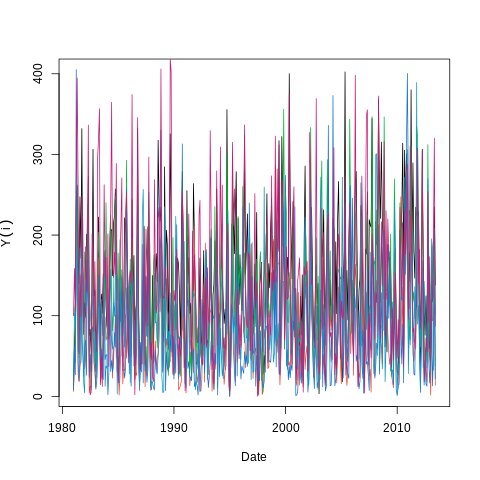

In [160]:
%%R
sttns_ = unique(df_aero2$NombreEstacion)
plot(df_aero2$Date[df_aero2$NombreEstacion==sttns_[1]],
     df_aero2$sttns_fill[df_aero2$NombreEstacion==sttns_[1]], type = 'l', col = 'black',
     xlab = 'Date', ylab = expression(Y(i)))
for(i in 2:6){
    lines(df_aero2$Date[df_aero2$NombreEstacion==sttns_[i]],
          df_aero2$sttns_fill[df_aero2$NombreEstacion==sttns_[i]], col = i)
}

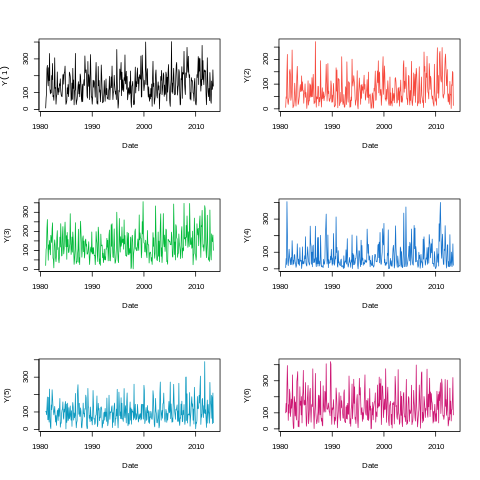

In [16]:
%%R
par(mfrow = c(3,2))
plot(df_aero2$Date[df_aero2$NombreEstacion==sttns_[1]],
     df_aero2$sttns_fill[df_aero2$NombreEstacion==sttns_[1]], type = 'l', col = 'black',
     xlab = 'Date', ylab = expression(Y(1)))
for(i in 2:6){
    plot(df_aero2$Date[df_aero$NombreEstacion==sttns_[i]],
          df_aero2$sttns_fill[df_aero$NombreEstacion==sttns_[i]], type = 'l', col = i,
         xlab = 'Date', ylab = paste0('Y(', i, ')'))
}

In [161]:
%%R
Data <- df_aero2 %>%
  dplyr::select(NombreEstacion, Date, sttns_fill) %>%
  spread(key = NombreEstacion, value = sttns_fill)
Data = Data[, c(1,5,2,6,4,3,7)]
names(Data) = c('Date', "Bucaramanga", "Cúcuta", "Ibagué",  "Medellín", "Manizales", "Bogotá")
X <- as.matrix(Data[,2:7]) # elimina fila del mes

sX <- scale(X) # escala los datos (x_{ij} - \bar{x}_{j})

head(sX)

     Bucaramanga     Cúcuta     Ibagué   Medellín  Manizales     Bogotá
[1,]  0.03596270 -0.9491036 -0.4601372 -1.7845426 -1.5770752 -1.2813344
[2,]  0.04078575 -0.1985269  0.1895915 -1.0389439 -0.3676766 -0.5095426
[3,] -0.26788993 -0.6878532 -0.4003666 -0.6751432 -0.1971572 -0.6275814
[4,]  0.44592260  4.5426847  1.4049273  1.2055653  1.2544077  1.3790771
[5,]  1.37194966  2.0725549  2.8028956  1.4690959  1.8806010  2.6103119
[6,] -0.71964967 -0.4818938  1.2732106  0.3404137  0.2843096 -0.8908986


In [162]:
%%R
Data2 <- df_aero %>%
  dplyr::select(NombreEstacion, Date, sttns_fill) %>%
  spread(key = NombreEstacion, value = sttns_fill)
Data2 = Data2[, c(1,5,2,6,4,3,7)]
names(Data2) = c('Date', "Bucaramanga", "Cúcuta", "Ibagué",  "Medellín", "Manizales", "Bogotá")
X2 <- as.matrix(Data2[,2:7]) # elimina fila del mes

sX2 <- scale(X2) # escala los datos (x_{ij} - \bar{x}_{j})

head(sX2)

     Bucaramanga     Cúcuta     Ibagué   Medellín  Manizales     Bogotá
[1,]   0.1105214 -0.8342433 -0.4104013 -1.7862235 -1.5606489 -1.2642671
[2,]   0.1153669 -0.0621732  0.2359130 -1.0294207 -0.3579916 -0.4936556
[3,]  -0.1947458 -0.5655117 -0.3509448 -0.6601532 -0.1884227 -0.6115138
[4,]   0.5223898  4.8148072  1.4448621  1.2488165  1.2550511  1.3920761
[5,]   1.4527280  2.2739431  2.8354839  1.5163071  1.8777539  2.6214281
[6,]  -0.6486087 -0.3536545  1.3138376  0.3706644  0.2903603 -0.8744283


## 2. Step 1: Finding the number and type of factors

This decision (total number $r$ of common factors) can be confirmed by the eigenvalues sequences of matrices $\hat{M}(k,N)$, as was described in Sections 3 and 4.2. Then, we obtain $r1$ and $r2$ by using the eigenvalues sequences of the sample SGCV matrices and looking for the number of large eigenvalues at the nonseasonal lags ($r1$) as well as at the seasonal lags ($r2$).

In [18]:
%%R
S <- 12
nObs <- nrow(sX) # 204 meses

EVMatrix <- t(sapply(0:36, FUN = function(h){

  # rezagos
  Xt <- sX[(h+1):nObs,]
  Xt_h <- sX[1:(nObs-h),]

  # Sample generalized autocovariance of lag h

  Ch <- ((S/nObs)^2) * (t(Xt) %*% Xt_h)


  # Five largest absolute eigenvalues

  abs(eigen(Ch)$values)[1:5]
}))

# Eigenvalues figure
EVData <- data.frame(Lag = 0:36)

# 185 filas (37 lags * 5 EV), 3 cols
# Valor C_h combinación lag-EV
EVData <- cbind(EVData, EVMatrix) %>%
  gather(key = "EV", value = "Value", 2:6)

In [19]:
%%R
head(EVData)

  Lag EV     Value
1   0  1 1.2836710
2   1  1 0.3858316
3   2  1 0.1112328
4   3  1 0.3672543
5   4  1 0.1406741
6   5  1 0.3639421


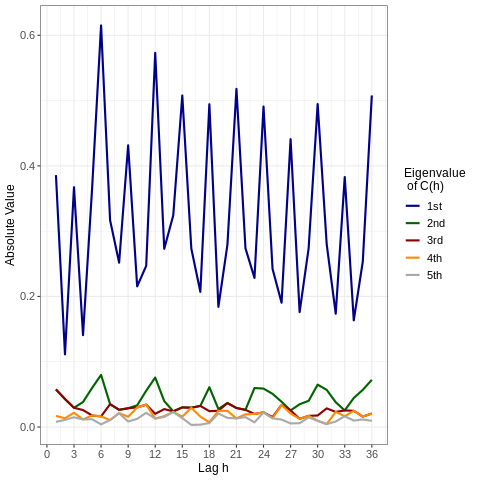

In [20]:
%%R
par(mfrow = c(1,1))
ggplot(filter(EVData, Lag >0), aes(x = Lag, y = Value, colour = EV)) +
  geom_line(linewidth = 1) +
  scale_x_continuous(breaks = seq(0, 36, by = 3)) +
  scale_color_manual(values = c("darkblue", "darkgreen", "darkred",
                                "darkorange", "darkgrey"),
                     labels = c("1st", "2nd", "3rd", "4th", "5th")) +
  labs(y = "Absolute Value", x = "Lag h", colour = "Eigenvalue \n of C(h)") +
  theme_bw() +
  theme(axis.title = element_text(size = 12),
        legend.title = element_text(size = 12),
        axis.text = element_text(size = 11),
        legend.text = element_text(size = 11))

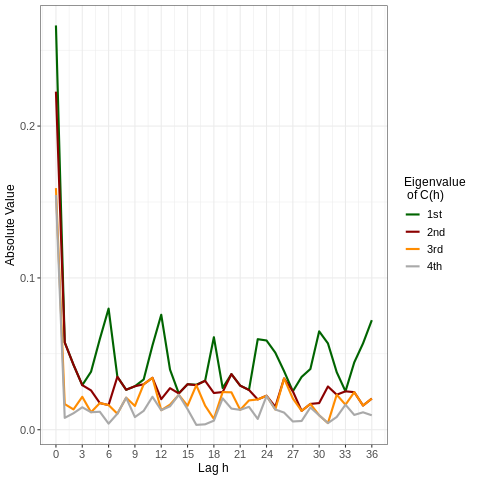

In [21]:
%%R
ggplot(filter(EVData, EV > 1), aes(x = Lag, y = Value, colour = EV)) +
  geom_line(linewidth = 1) +
  scale_x_continuous(breaks = seq(0, 36, by = 3)) +
  scale_color_manual(values = c("darkgreen", "darkred",
                                "darkorange", "darkgrey"),
                     labels = c("1st", "2nd", "3rd", "4th", "5th")) +
  labs(y = "Absolute Value", x = "Lag h", colour = "Eigenvalue \n of C(h)") +
  theme_bw() +
  theme(axis.title = element_text(size = 12),
        legend.title = element_text(size = 12),
        axis.text = element_text(size = 11),
        legend.text = element_text(size = 11))

+ applying once the Lam and Yao (2012) criterion

In [22]:
%%R
rmax <- 12 #round(ncol(X)/2,digits = 0)
k0 = 3 # default lagk = 0 Maximum number of lags considered in the combined matrix.
LamYaotest(sX, k0, rmax)$r1

[1] 1


+ number of factors is estimated using  Caro and Peña (2020) test

In [23]:
%%R
CaroPenatest(sX, k0, rmax)$r1

[1] 1


## 3. Step 2: Finding a model for the factors

The first computes a preliminary estimation of the submatrix $P_1$ by using the eigenvectors associated to the first $r_1$ eigenvalues of $\hat{C}(k,N)$, for some $k \geq 0 $, and obtains the transformed time series $z_t = \hat{P}_1^T y_t $ to identify ARIMA models for each of the components of $z_t$. In the same way, obtain the $r_2$ transformed time series $w_t = \hat{P}_2^T  y_t $ and identify pure seasonal ARIMA models for the components of $w_t$, as specified in Section 2.

In [24]:
%%R
S <- 12
nObs <- nrow(sX) #204 meses
h <- 12

(nObs/S)

Xt <- sX[(h+1):nObs,]
Xt_h <- sX[1:(nObs-h),]

# matriz de autocovarianza muestral generalizada para rezago h
Ch <- ((S/nObs)^2) * (t(Xt) %*% Xt_h)

print(range(Ch)) # 0.2548381 0.6055674
print(head(Ch[,1:6]))

[1] 0.05631897 0.13345608
            Bucaramanga     Cúcuta     Ibagué   Medellín  Manizales     Bogotá
Bucaramanga  0.07996122 0.07631732 0.09598212 0.08043755 0.10224233 0.09968152
Cúcuta       0.06187581 0.06495302 0.07027333 0.05631897 0.11190016 0.09800267
Ibagué       0.08262799 0.07382940 0.11222095 0.09238429 0.11799092 0.10563789
Medellín     0.09800509 0.06847117 0.09303776 0.12122757 0.09208861 0.05732487
Manizales    0.10711267 0.09062638 0.11121983 0.07660268 0.13345608 0.12524732
Bogotá       0.09127686 0.11116653 0.11104510 0.06105853 0.13275329 0.12678099


In [25]:
%%R
# eigenvectors de Ch (de acuerdo al gráfico se toman dos factores)
Load <- Re(eigen(Ch)$vectors[,1:2])
print(Load)
# Factors
Fac <- sX %*% Load
#  num [1:204, 1:2] 2.062 3.247 1.469 0.891 -8.091 ... #str(Fac)

# Common components
Chi <- Fac %*% t(Load)
print(dim(Chi))
colnames(Chi) <- colnames(X)
print(head(Chi[,1:6]))

          [,1]        [,2]
[1,] 0.3833104  0.06819511
[2,] 0.3364405 -0.24440586
[3,] 0.4208365  0.16980850
[4,] 0.3732449  0.81961848
[5,] 0.4641937 -0.18966888
[6,] 0.4560592 -0.44612950
[1] 390   6
     Bucaramanga     Cúcuta     Ibagué   Medellín  Manizales     Bogotá
[1,] -0.98095891 -0.7284748 -1.1183491 -1.2832975 -1.0693603 -0.9374597
[2,] -0.32428064 -0.1413266 -0.4007414 -0.6705155 -0.2644811 -0.1374926
[3,] -0.44454144 -0.3432910 -0.5026939 -0.5489547 -0.4963849 -0.4476479
[4,]  1.46656413  1.5021521  1.5430823  0.8960233  1.9683328  2.1173377
[5,]  1.90477281  1.7491948  2.0671208  1.6633182  2.3758993  2.4002911
[6,]  0.04293449 -0.2384164  0.1332879  0.7253066 -0.1950610 -0.4273825


In [26]:
%%R
t(Load) %*% Load

           [,1]       [,2]
[1,] 1.00000000 0.02978733
[2,] 0.02978733 1.00000000


The observation matrix we propose is the matrix $C = PH$, where $H =
[H(l, k)]$ is of dimension $r \times r^*$ and its entries are given in the following way.
For the $i$th row we have three cases:
+ (i) if $1 ≤ i ≤ r_1$, we set $H(i, r_{11} + \cdots + r_{1,i-1} + 1) = 1 $ with the convention $r_{1,0} = 0$.

+ (ii) if $r_1 + 1 ≤ i ≤ r_1 + r_2$, we put $H(i, r_1^* + r_{21} + \cdots + r_{2, i - r_1 -1} + 1) = 1$ with $r_{2,0} = 0$.

+ (iii) if $r_1 + r_2 + 1 ≤ i ≤ r$, we set $H(i, r_1^* + r_2^* + r_{31} + \cdots + r_{3,i-r_1-r_2-1} + 1) = 1$, defining $r_{3,0} = 0$.

In [27]:
%%R
Load_ = Load
Load_[1,2] = 0
t(Load_) %*% Load_

            [,1]        [,2]
[1,] 1.000000000 0.003647433
[2,] 0.003647433 0.995349427


In [28]:
%%R
P_Nieto2016 = matrix(c(30.74, 25.58, 44.62, 43.94, 40.83, 23.38,
                       0.00, -0.62, -0.43, 0.71, -0.56, -0.18),
                     byrow = FALSE, nr = 6)

#t(P_Nieto2016)
t(P_Nieto2016) %*% P_Nieto2016

         [,1]     [,2]
[1,] 7734.665 -30.9220
[2,]  -30.922   1.4194


\[ $\hat{\Sigma}_e$ =
\begin{bmatrix}
2712.39 & 0 & \cdots & \cdots &  \cdots & 0 \\
0 & 3070.49 & 0 & \cdots & \cdots & \vdots \\
\vdots & 0 & 3794.05 & 0 &   \cdots & \vdots \\
\vdots & \vdots & 0 & 1709.43 & 0 & \vdots \\
\vdots & \vdots & \vdots & 0 & 1463.79 & 0 \\
0 & 0 & 0 & 0 & 0 & 869.58
\end{bmatrix}
\]

In [29]:
%%R
Fac_ <- X %*% Load
# Common components
Chi_ <- Fac_ %*% t(Load)
resid <- X - Chi_
R_hat <- diag(colMeans(resid^2))
R_hat

         [,1]    [,2]     [,3]     [,4]     [,5]     [,6]
[1,] 2603.584    0.00    0.000   0.0000    0.000    0.000
[2,]    0.000 2246.21    0.000   0.0000    0.000    0.000
[3,]    0.000    0.00 3131.584   0.0000    0.000    0.000
[4,]    0.000    0.00    0.000 797.0711    0.000    0.000
[5,]    0.000    0.00    0.000   0.0000 1670.566    0.000
[6,]    0.000    0.00    0.000   0.0000    0.000 1161.024


## 4. Modelos Factores

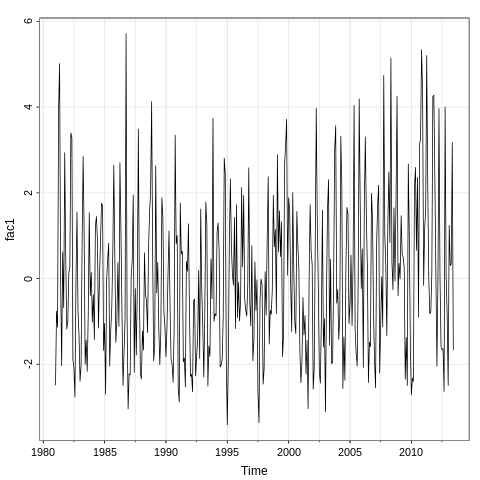

In [30]:
%%R
fac1 <- ts(Fac[,1], start = c(1981, 1), end = c(2013, 06), frequency = 12)

tsplot(fac1) # gráfico factor 1

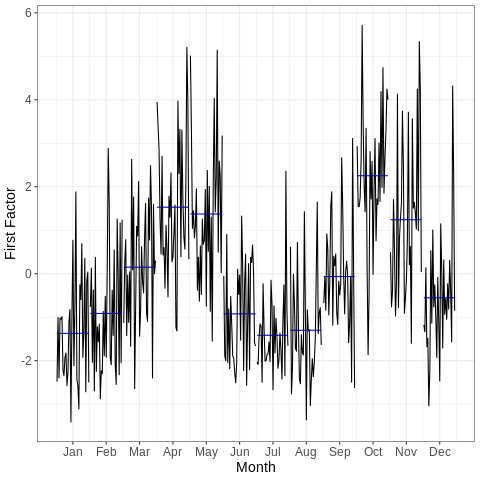

In [31]:
%%R
ggsubseriesplot(fac1) +
  labs(y = "First Factor") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

In [32]:
%%R
#H0: No significant autocorrelation detected
#p.value < 0.05 then "Reject H0: The series has significant autocorrelation")
Box.test(fac1, lag = 24, type = "Ljung-Box") # p-value < 0.05 (R. H0: indep)


	Box-Ljung test

data:  fac1
X-squared = 789.81, df = 24, p-value < 2.2e-16



In [121]:
%%R
print(nsdiffs(fac1)) # núm de diff estacional para remover la comp estacional (volver la serie estacionaria)
# H0: The time series is trend stationary.
# test_stat > crit_vals["5pct"] then "Reject H0: Series is NOT stationary"
summary(ur.kpss(fac1)) # test-statistic = 0.915 > Valor crítico R. H0 (concluye No-estacionariedad)

[1] 0

####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.915 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



In [123]:
%%R
aTSA::adf.test(fac1) # Type 1: no drift no trend
# p-value = 0.01 < 0.05 (R. H0, concluye que no hay raíz unitaria, por lo tanto es estacionaria)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -14.48    0.01
[2,]   1 -14.21    0.01
[3,]   2 -14.36    0.01
[4,]   3 -11.01    0.01
[5,]   4  -7.02    0.01
[6,]   5  -4.71    0.01
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -14.46    0.01
[2,]   1 -14.20    0.01
[3,]   2 -14.34    0.01
[4,]   3 -11.00    0.01
[5,]   4  -7.01    0.01
[6,]   5  -4.70    0.01
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 -14.65    0.01
[2,]   1 -14.50    0.01
[3,]   2 -14.82    0.01
[4,]   3 -11.57    0.01
[5,]   4  -7.52    0.01
[6,]   5  -5.10    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


### Identificación de la componente ARMA estacional y la componente ARMA ordinaria

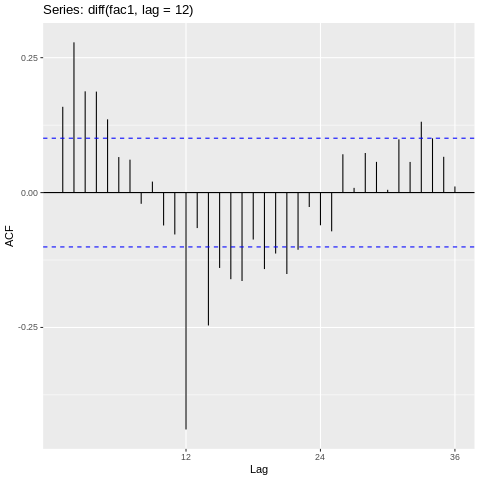

In [34]:
%%R
ggAcf(diff(fac1, lag = 12), lag.max = 36) # q = 1,2,3,4,5 y Q = 1

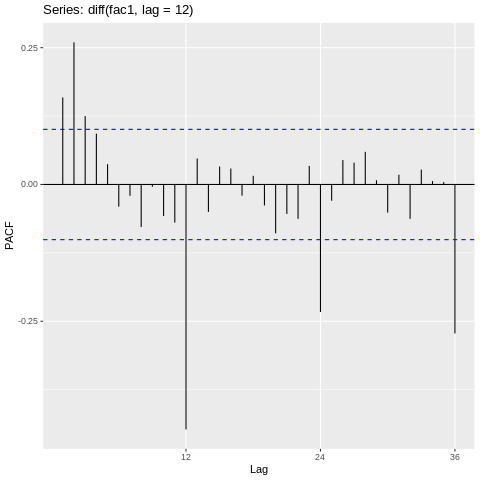

In [35]:
%%R
ggPacf(diff(fac1, lag = 12), lag.max = 36) # p =1,2,3 y P = 1,2,3

In [36]:
%%R
fit_auto = auto.arima(fac1, seasonal = TRUE)
#fit_auto = auto.arima(fac1, d = 0, max.p = 0, max.q = 0, seasonal = TRUE)
fit_auto

Series: fac1 
ARIMA(0,1,1)(0,0,2)[12] with drift 

Coefficients:
          ma1    sma1    sma2    drift
      -0.8544  0.3562  0.2416  -0.0021
s.e.   0.0487  0.0540  0.0485   0.0198

sigma^2 = 2.846:  log likelihood = -755.19
AIC=1520.38   AICc=1520.54   BIC=1540.2


In [62]:
%%R
# default: (5,2,5) x (2,1,2)
auto.arima(fac1, d = 1, max.p = 5, max.q = 5, seasonal = TRUE)

Series: fac1 
ARIMA(0,1,1)(0,0,2)[12] with drift 

Coefficients:
          ma1    sma1    sma2    drift
      -0.8544  0.3562  0.2416  -0.0021
s.e.   0.0487  0.0540  0.0485   0.0198

sigma^2 = 2.846:  log likelihood = -755.19
AIC=1520.38   AICc=1520.54   BIC=1540.2


In [68]:
%%R
# q=5 Q=1 & p=3 P=3 (3,1,5) x (3,1,1)
# default (2,1,3) x (1,1,1)
# traza de ejecución:
# (0,1,0) x (0,1,1) -> (0 0 0) x (0 0 1)
# (0,1,1) x (0,1,1) -> (0 0 1) x (0 0 1)
# (0,1,1) x (0,1,2) -> (0 0 1) x (0 0 1)
# (0,1,1) x (0,1,3) -> (0 0 1) x (0 0 1)
# (2,1,3) x (1,1,1) -> (1 0 1) x (1 0 1)
# (2,1,3) x (2,1,1) -> Error
# (2,1,3) x (2,1,2) -> Error
# (2,1,3) x (3,1,2) -> Error
sarimaSpec(fac1, maxorder = c(0,1,1), maxsea = c(0,1,3), criterion = "aic",
           period = 12, output = TRUE,  method = "ML", include.mean = FALSE)

Selected order (p,d,q,P,D,Q):  0 0 1 0 0 1 
minimum criterion:  1513.728 
$order
[1] 0 0 1 0 0 1

$crit
[1] 1513.728

$include.mean
[1] FALSE



### Ajuste de modelos

initial  value 0.905120 
iter   2 value 0.508748
iter   3 value 0.431861
iter   4 value 0.418571
iter   5 value 0.412606
iter   6 value 0.410504
iter   7 value 0.410314
iter   8 value 0.410156
iter   9 value 0.410155
iter  10 value 0.410155
iter  11 value 0.410155
iter  11 value 0.410155
iter  11 value 0.410155
final  value 0.410155 
converged
initial  value 0.391806 
iter   2 value 0.381464
iter   3 value 0.370282
iter   4 value 0.369903
iter   5 value 0.369704
iter   6 value 0.369681
iter   7 value 0.369680
iter   8 value 0.369680
iter   8 value 0.369680
final  value 0.369680 
converged
<><><><><><><><><><><><><><>
 
Coefficients: 
     Estimate     SE  t.value p.value
ma1   -0.8294 0.0391 -21.1923  0.0000
sma1  -0.9631 0.0969  -9.9342  0.0000
sma2  -0.0369 0.0558  -0.6609  0.5091

sigma^2 estimated as 1.87239 on 374 degrees of freedom 
 
AIC = 3.598457  AICc = 3.598628  BIC = 3.640179 
 


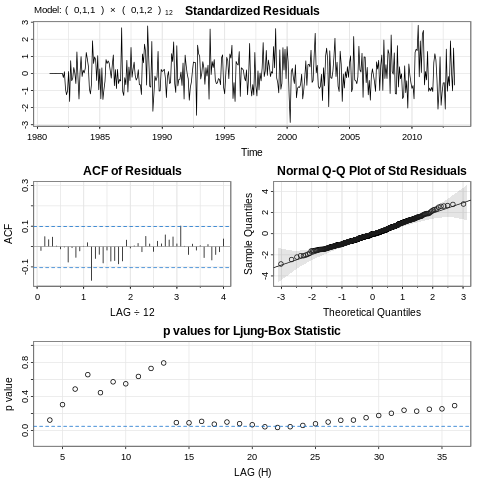

In [71]:
%%R
SARIMA_f1_m1 <- astsa::sarima(fac1, p = 0, d = 1, q = 1, P = 0, D = 1, Q = 2, S = 12, no.constant = T)

initial  value 0.905120 
iter   2 value 0.751202
iter   3 value 0.704634
iter   4 value 0.674852
iter   5 value 0.673565
iter   6 value 0.673082
iter   7 value 0.673042
iter   8 value 0.673041
iter   9 value 0.673041
iter   9 value 0.673041
iter   9 value 0.673041
final  value 0.673041 
converged
initial  value 0.659960 
iter   2 value 0.640179
iter   3 value 0.640123
iter   4 value 0.640112
iter   4 value 0.640112
final  value 0.640112 
converged
<><><><><><><><><><><><><><>
 
Coefficients: 
     Estimate     SE  t.value p.value
sma1       -1 0.0456 -21.9319       0

sigma^2 estimated as 3.22044 on 376 degrees of freedom 
 
AIC = 4.128712  AICc = 4.12874  BIC = 4.149573 
 


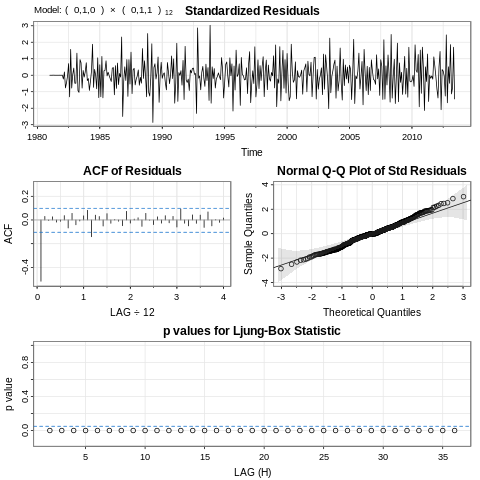

In [72]:
%%R
SARIMA_f1_m2 <- astsa::sarima(fac1, p = 0, d = 1, q = 0, P = 0, D = 1, Q = 1, S = 12, no.constant = T)

### Análisis de residuales

In [74]:
%%R
#fitdf: number of degrees of freedom to be subtracted if x is a series of residuals.
residuals_f1_m1 = SARIMA_f1_m1$fit$residuals
Box.test(residuals_f1_m1, lag = (length(residuals_f1_m1)/4), type = "Ljung-Box", fitdf = 2)
# p-value > 0.05 (No R. H0, concluye No significant autocorrelation detected)


	Box-Ljung test

data:  residuals_f1_m1
X-squared = 81.34, df = 95, p-value = 0.8399



In [75]:
%%R
residuals_f1_m2 = SARIMA_f1_m2$fit$residuals
Box.test(residuals_f1_m2, lag = (length(residuals_f1_m2)/4), type = "Ljung-Box", fitdf = 2)
# p-value < 0.05 (R. H0, concluye The series has significant autocorrelation)


	Box-Ljung test

data:  residuals_f1_m2
X-squared = 198.91, df = 95, p-value = 2.446e-09



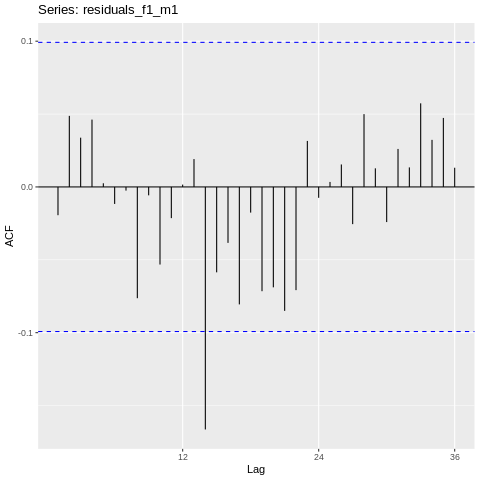

In [86]:
%%R
ggAcf(residuals_f1_m1, lag.max = 36)

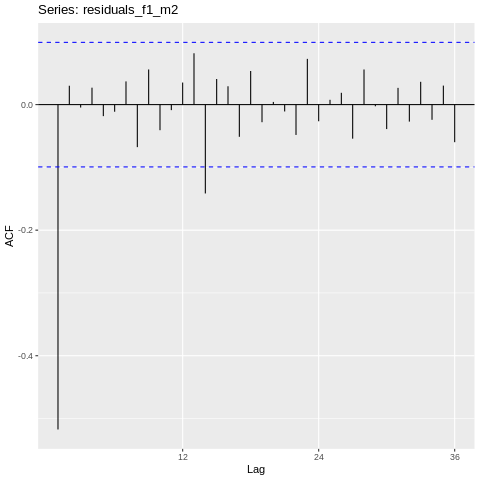

In [87]:
%%R
ggAcf(residuals_f1_m2, lag.max = 36)

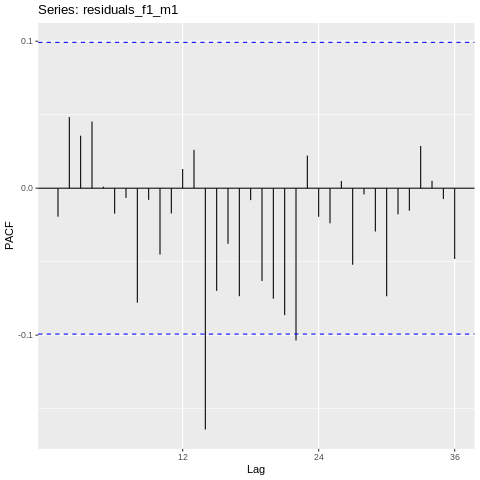

In [99]:
%%R
ggPacf(residuals_f1_m1, lag.max = 36)

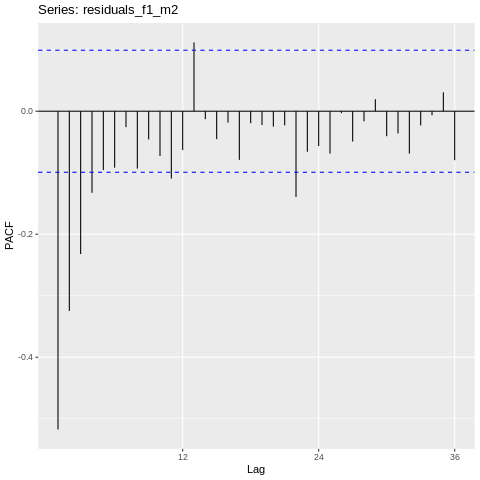

In [85]:
%%R
ggPacf(residuals_f1_m2, lag.max = 36)

In [95]:
%%R
# H0: normalidad de x
tseries::jarque.bera.test(residuals_f1_m1) # pvalue = 0.057 > 0.05 (No R. H0, concluye normalidad)


	Jarque Bera Test

data:  residuals_f1_m1
X-squared = 5.7208, df = 2, p-value = 0.05725



In [96]:
%%R
tseries::jarque.bera.test(residuals_f1_m2) # pvalue = 0.5562 > 0.05 (No R. H0, concluye normalidad)


	Jarque Bera Test

data:  residuals_f1_m2
X-squared = 1.1733, df = 2, p-value = 0.5562



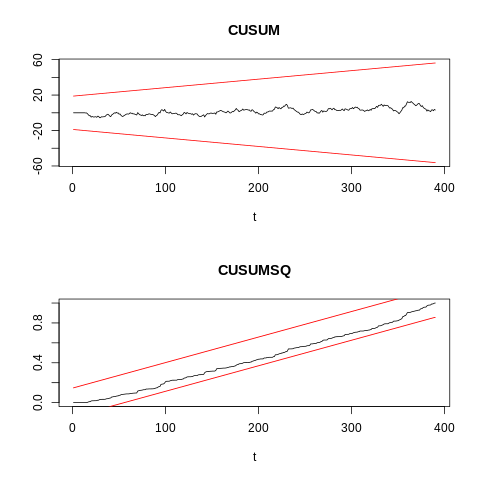

In [97]:
%%R
res=residuals_f1_m1
cum=cumsum(res)/sd(res)
N=length(res)
cumq=cumsum(res^2)/sum(res^2)
Af=0.948 ###Cuantil del 95% para la estad?stica cusum
co=0.14422####Valor del cuantil aproximado para cusumsq para n/2
LS=Af*sqrt(N)+2*Af*c(1:length(res))/sqrt(N)
LI=-LS
LQS=co+(1:length(res))/N
LQI=-co+(1:length(res))/N
par(mfrow=c(2,1))
plot(cum,type="l",ylim=c(min(LI),max(LS)),xlab="t",ylab="",main="CUSUM")
lines(LS,type="S",col="red")
lines(LI,type="S",col="red")
#CUSUM Square
plot(cumq,type="l",xlab="t",ylab="",main="CUSUMSQ")
lines(LQS,type="S",col="red")
lines(LQI,type="S",col="red")

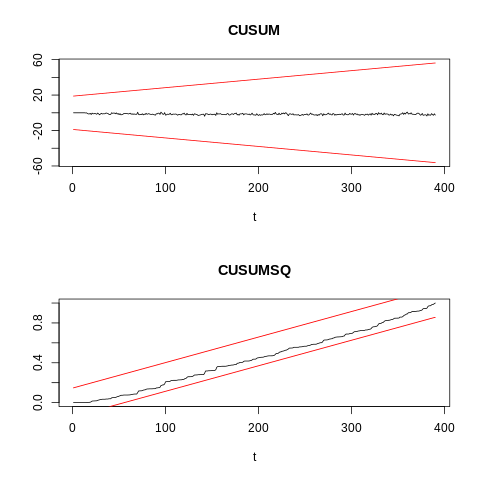

In [98]:
%%R
res=residuals_f1_m2
cum=cumsum(res)/sd(res)
N=length(res)
cumq=cumsum(res^2)/sum(res^2)
Af=0.948 ###Cuantil del 95% para la estad?stica cusum
co=0.14422####Valor del cuantil aproximado para cusumsq para n/2
LS=Af*sqrt(N)+2*Af*c(1:length(res))/sqrt(N)
LI=-LS
LQS=co+(1:length(res))/N
LQI=-co+(1:length(res))/N
par(mfrow=c(2,1))
plot(cum,type="l",ylim=c(min(LI),max(LS)),xlab="t",ylab="",main="CUSUM")
lines(LS,type="S",col="red")
lines(LI,type="S",col="red")
#CUSUM Square
plot(cumq,type="l",xlab="t",ylab="",main="CUSUMSQ")
lines(LQS,type="S",col="red")
lines(LQI,type="S",col="red")

## Factor 2

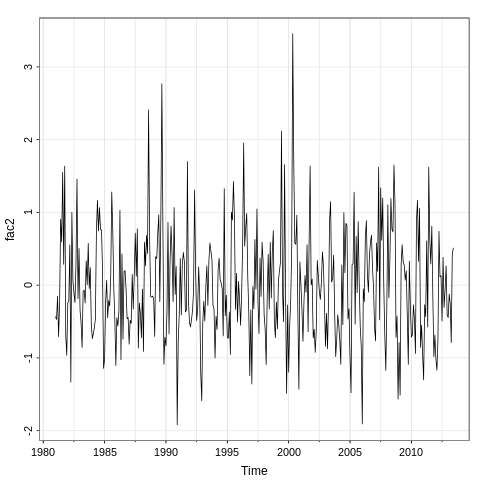

In [100]:
%%R
fac2 <- ts(Fac[,2], start = c(1981, 1), end = c(2013, 06), frequency = 12)

tsplot(fac2) # gráfico factor 1

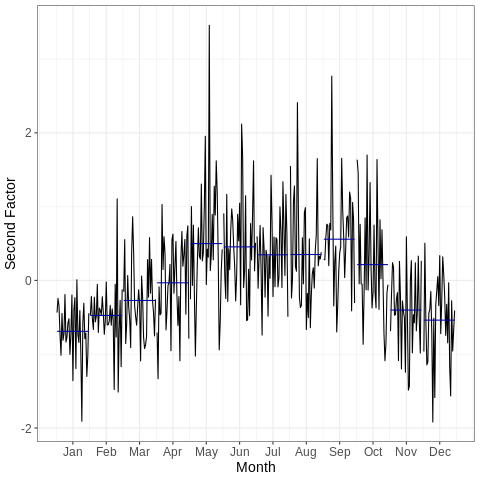

In [101]:
%%R
ggsubseriesplot(fac2) +
  labs(y = "Second Factor") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

In [102]:
%%R
#H0: No significant autocorrelation detected
#p.value < 0.05 then "Reject H0: The series has significant autocorrelation")
Box.test(fac2, lag = 24, type = "Ljung-Box") # p-value < 0.05 (R. H0, concluye The series has significant autocorrelation)


	Box-Ljung test

data:  fac2
X-squared = 414.37, df = 24, p-value < 2.2e-16



In [103]:
%%R
print(nsdiffs(fac2)) # seasonally stationary series
# H0: The time series is trend stationary.
# test_stat > crit_vals["5pct"] then "Reject H0: Series is NOT stationary"
# test sensible al valor de rezago (12×(n/100))^(1/4)
summary(ur.kpss(fac2, lags = 'long')) # test-statistic = 0.0492  < Valor crítico No R H0 (concluye estacionariedad)

[1] 0

####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 16 lags. 

Value of test-statistic is: 0.0492 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



In [120]:
%%R
aTSA::adf.test(fac2, nlag = 12) # Type 1: no drift no trend
# p-value = 0.01 < 0.05 (R. H0, concluye que no hay raíz unitaria, por lo tanto es estacionaria)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
      lag    ADF p.value
 [1,]   0 -14.37    0.01
 [2,]   1 -10.81    0.01
 [3,]   2 -10.77    0.01
 [4,]   3 -11.07    0.01
 [5,]   4 -11.40    0.01
 [6,]   5 -12.52    0.01
 [7,]   6 -10.42    0.01
 [8,]   7 -10.00    0.01
 [9,]   8  -9.04    0.01
[10,]   9  -8.25    0.01
[11,]  10  -6.36    0.01
[12,]  11  -4.81    0.01
Type 2: with drift no trend 
      lag    ADF p.value
 [1,]   0 -14.35    0.01
 [2,]   1 -10.80    0.01
 [3,]   2 -10.76    0.01
 [4,]   3 -11.05    0.01
 [5,]   4 -11.38    0.01
 [6,]   5 -12.51    0.01
 [7,]   6 -10.41    0.01
 [8,]   7  -9.99    0.01
 [9,]   8  -9.03    0.01
[10,]   9  -8.24    0.01
[11,]  10  -6.36    0.01
[12,]  11  -4.81    0.01
Type 3: with drift and trend 
      lag    ADF p.value
 [1,]   0 -14.34    0.01
 [2,]   1 -10.79    0.01
 [3,]   2 -10.76    0.01
 [4,]   3 -11.06    0.01
 [5,]   4 -11.40    0.01
 [6,]   5 -12.52    0.01
 [7,]   6 -10.42    0.01
 [8,]  

### Identificación de la componente ARMA estacional y la componente ARMA ordinaria

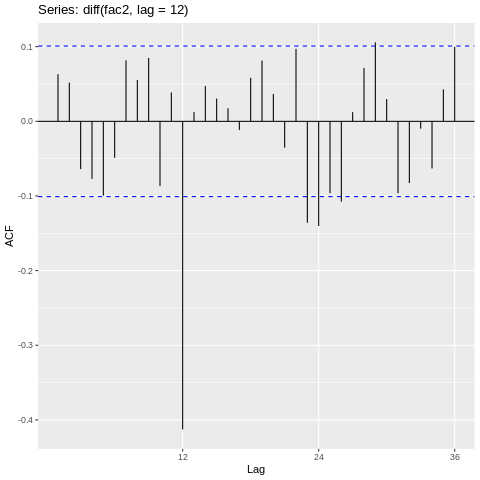

In [104]:
%%R
ggAcf(diff(fac2, lag =12), lag.max = 36) # q = 0 y Q = 2

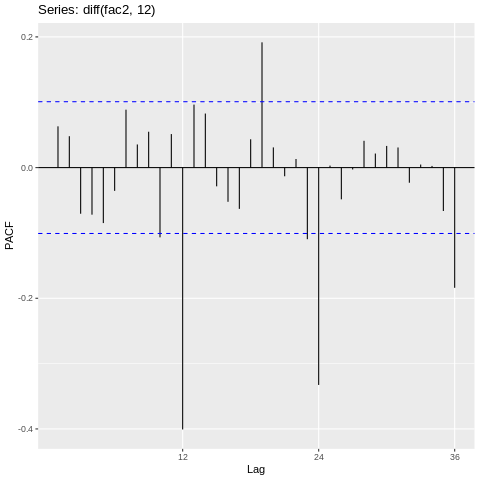

In [105]:
%%R
ggPacf(diff(fac2,12), lag.max = 36) # p=0 y P=3

In [106]:
%%R
fit_auto2 = auto.arima(fac2, seasonal = TRUE)
#fit_auto2 = auto.arima(fac2, d = 0, max.p = 0, max.q = 0, seasonal = TRUE)
fit_auto2

Series: fac2 
ARIMA(1,0,0)(2,0,0)[12] with zero mean 

Coefficients:
         ar1    sar1    sar2
      0.1856  0.2630  0.1589
s.e.  0.0522  0.0521  0.0514

sigma^2 = 0.4541:  log likelihood = -398.87
AIC=805.75   AICc=805.85   BIC=821.61


In [127]:
%%R
auto.arima(fac2, d = 0, max.p = 1, max.q = 5, seasonal = TRUE)

Series: fac2 
ARIMA(1,0,0)(2,0,0)[12] with zero mean 

Coefficients:
         ar1    sar1    sar2
      0.1856  0.2630  0.1589
s.e.  0.0522  0.0521  0.0514

sigma^2 = 0.4541:  log likelihood = -398.87
AIC=805.75   AICc=805.85   BIC=821.61


In [130]:
%%R
# q=1 Q=2 & p=1 P=3 (1,0,1) x (3,1,2)
# default (2,1,3) x (1,1,1)
# traza de ejecución:
# (1,0,1) x (3,1,2) -> (0 0 1) x (2 0 1)
# (1,0,1) x (2,1,2) -> (0 0 1) x (2 0 1)
# (2,0,1) x (2,1,2) -> (0 0 1) x (2 0 1)
sarimaSpec(fac2, maxorder = c(1,0,1), maxsea = c(2,1,2), criterion = "aic",
           period = 12, output = TRUE,  method = "ML", include.mean = FALSE)

Selected order (p,d,q,P,D,Q):  0 0 1 2 0 1 
minimum criterion:  768.4309 
$order
[1] 0 0 1 2 0 1

$crit
[1] 768.4309

$include.mean
[1] FALSE



### Ajuste de modelos

initial  value 0.609225 
iter   2 value 0.493364
iter   3 value 0.441546
iter   4 value 0.441079
iter   5 value 0.441072
iter   6 value 0.441071
iter   6 value 0.441071
iter   6 value 0.441071
final  value 0.441071 
converged
initial  value 0.448959 
iter   2 value 0.448696
iter   3 value 0.448628
iter   4 value 0.448623
iter   5 value 0.448623
iter   5 value 0.448623
iter   5 value 0.448623
final  value 0.448623 
converged
<><><><><><><><><><><><><><>
 
Coefficients: 
     Estimate     SE t.value p.value
ar1    0.1930 0.0504  3.8279   2e-04
sar1   0.3361 0.0501  6.7125   0e+00
sar2   0.2487 0.0517  4.8124   0e+00

sigma^2 estimated as 2.426244 on 387 degrees of freedom 
 
AIC = 3.755636  AICc = 3.755795  BIC = 3.796314 
 


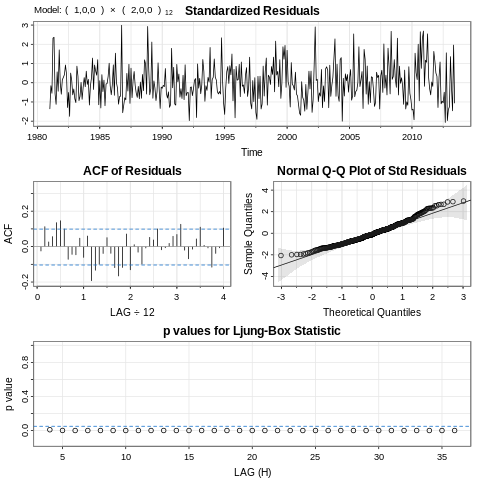

In [134]:
%%R
SARIMA_f2_m1 <- sarima(fac1, p = 1, d = 0, q = 0, P = 2, D = 0, Q = 0, S = 12,
                       no.constant = T)

initial  value 0.650563 
iter   2 value 0.533819
iter   3 value 0.533649
iter   4 value 0.533635
iter   4 value 0.533635
final  value 0.533635 
converged
initial  value 0.531185 
iter   2 value 0.531165
iter   3 value 0.531164
iter   3 value 0.531164
iter   3 value 0.531164
final  value 0.531164 
converged
<><><><><><><><><><><><><><>
 
Coefficients: 
     Estimate     SE t.value p.value
sar1  -0.4595 0.0464 -9.8976       0

sigma^2 estimated as 2.871398 on 377 degrees of freedom 
 
AIC = 3.910786  AICc = 3.910814  BIC = 3.931606 
 


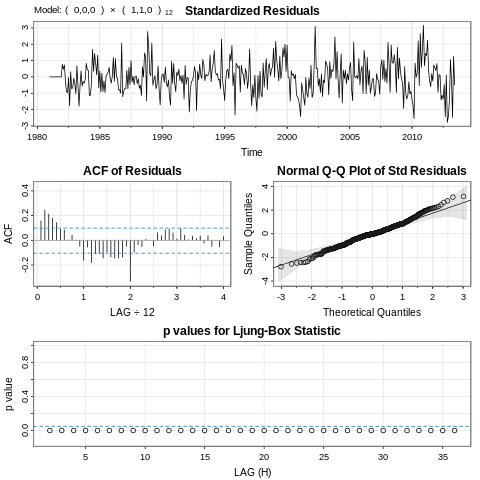

In [135]:
%%R
SARIMA_f2_m2 <- sarima(fac1, p = 0, d = 0, q = 0, P = 1, D = 1, Q = 0, S = 12,
                       no.constant = T)

### Análisis de residuales

In [137]:
%%R
#fitdf: number of degrees of freedom to be subtracted if x is a series of residuals.
residuals_f2_m1 = SARIMA_f2_m1$fit$residuals
Box.test(residuals_f2_m1, lag = (length(residuals_f2_m1)/4), type = "Ljung-Box", fitdf = 2)
# p-value < 0.05 (R. H0, concluye significant autocorrelation detected)


	Box-Ljung test

data:  residuals_f2_m1
X-squared = 234.39, df = 95, p-value = 8.871e-14



In [138]:
%%R
#fitdf: number of degrees of freedom to be subtracted if x is a series of residuals.
residuals_f2_m2 = SARIMA_f2_m2$fit$residuals
Box.test(residuals_f2_m2, lag = (length(residuals_f2_m1)/4), type = "Ljung-Box", fitdf = 2)
# p-value < 0.05 (R. H0, concluye significant autocorrelation detected)


	Box-Ljung test

data:  residuals_f2_m2
X-squared = 280.75, df = 95, p-value < 2.2e-16



In [139]:
%%R
# H0: normalidad de x
tseries::jarque.bera.test(residuals_f2_m1) # pvalue = 4.801e-05 < 0.05 (R. H0, No concluye normalidad)


	Jarque Bera Test

data:  residuals_f2_m1
X-squared = 19.888, df = 2, p-value = 4.801e-05



In [140]:
%%R
# H0: normalidad de x
tseries::jarque.bera.test(residuals_f2_m2) # pvalue = 0.05195 > 0.05 (No R. H0, concluye normalidad)


	Jarque Bera Test

data:  residuals_f2_m2
X-squared = 5.9151, df = 2, p-value = 0.05195



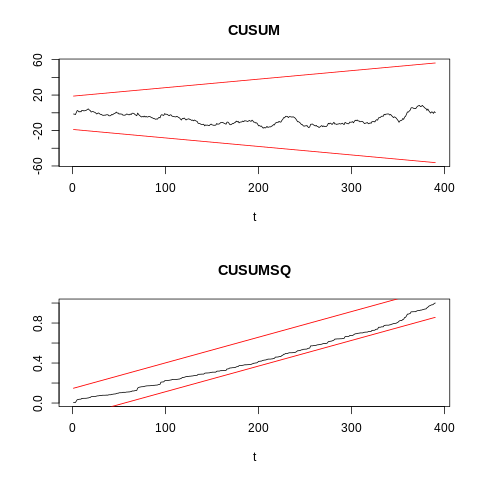

In [141]:
%%R
# Are the model parameters stable over time?
res=residuals_f2_m1
cum=cumsum(res)/sd(res)
N=length(res)
cumq=cumsum(res^2)/sum(res^2)
Af=0.948 ###Cuantil del 95% para la estad?stica cusum
co=0.14422####Valor del cuantil aproximado para cusumsq para n/2
LS=Af*sqrt(N)+2*Af*c(1:length(res))/sqrt(N)
LI=-LS
LQS=co+(1:length(res))/N
LQI=-co+(1:length(res))/N
par(mfrow=c(2,1))
plot(cum,type="l",ylim=c(min(LI),max(LS)),xlab="t",ylab="",main="CUSUM")
lines(LS,type="S",col="red")
lines(LI,type="S",col="red")
#CUSUM Square
plot(cumq,type="l",xlab="t",ylab="",main="CUSUMSQ")
lines(LQS,type="S",col="red")
lines(LQI,type="S",col="red")

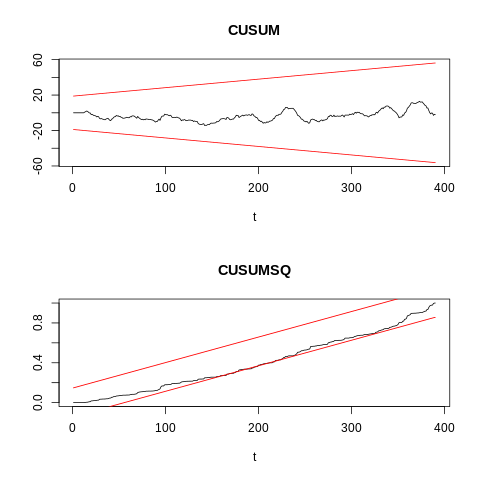

In [142]:
%%R
res=residuals_f2_m2
cum=cumsum(res)/sd(res)
N=length(res)
cumq=cumsum(res^2)/sum(res^2)
Af=0.948 ###Cuantil del 95% para la estad?stica cusum
co=0.14422####Valor del cuantil aproximado para cusumsq para n/2
LS=Af*sqrt(N)+2*Af*c(1:length(res))/sqrt(N)
LI=-LS
LQS=co+(1:length(res))/N
LQI=-co+(1:length(res))/N
par(mfrow=c(2,1))
plot(cum,type="l",ylim=c(min(LI),max(LS)),xlab="t",ylab="",main="CUSUM")
lines(LS,type="S",col="red")
lines(LI,type="S",col="red")
#CUSUM Square
plot(cumq,type="l",xlab="t",ylab="",main="CUSUMSQ")
lines(LQS,type="S",col="red")
lines(LQI,type="S",col="red")

## 5. Visualización Factores y Cargas

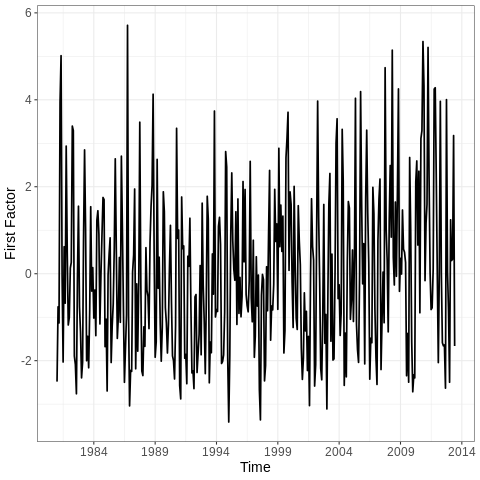

In [143]:
%%R
DataFac <- data.frame(Time = Data$Date, Fac1 = Fac[,1], Fac2 = Fac[,2])

ggplot(DataFac, aes(x = Time, y = Fac1)) +
  geom_line(linewidth = 0.8) +
  scale_x_date(date_breaks = "5 years", date_labels = "%Y") +
  labs(x = "Time", y = "First Factor") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

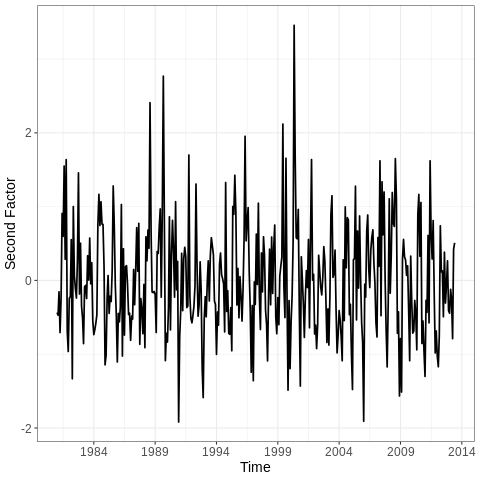

In [144]:
%%R
# Gráfico ts de Factor 2
ggplot(DataFac, aes(x = Time, y = Fac2)) +
  geom_line(linewidth = 0.8) +
  scale_x_date(date_breaks = "5 years", date_labels = "%Y") +
  labs(x = "Time", y = "Second Factor") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

In [165]:
%%R
Fac2_ <- sX2 %*% Load
DataFac2 <- data.frame(Time = Data2$Date, Fac1 = Fac2_[,1], Fac2 = Fac2_[,2])
print(dim(DataFac2))
head(DataFac2)

[1] 480   3
        Time        Fac1       Fac2
1 1981-01-01 -2.37874394 -0.4622471
2 1981-02-01 -0.65295513 -0.4924751
3 1981-03-01 -1.02534949 -0.1671812
4 1981-04-01  4.11175482 -0.7313301
5 1981-05-01  5.14828938 -0.2580614
6 1981-06-01  0.05964951  0.9041434


In [166]:
%%R
# la idea es hacer rolling con los datos que no ha visto el modelo
# e.d. se ajusto el modelo con 390 puntos? si hay 480 disponibles no sería mucho rolling?
# creo que hay que calcular primero el factor y lueg si hacer rolling
# forecast::tsCV
fSarima <- function(y,h){
    # ajusta siempre el mismo modelo como en backtest, lo que cambia son los parámetros
    #forecast::forecast(arima(y,order=c(1,1,0)), h =h)
    #astsa::sarima(y, p = 0, d = 1, q = 1, P = 0, D = 1, Q = 2, S = 12, no.constant = T)
    forecast::forecast(Arima(y, c(0, 1, 1), seasonal = list(order = c(0, 1, 2), period = 12), lambda = 0), h = h)
}

errorSarima <- forecast::tsCV(y = DataFac2$Fac1, forecastfunction = fSarima,
                              h = 1, initial = 391) # window = NULL (a rolling window will not be used.)
print(sum(!is.na(errorSarima)))
sqrt(mean(errorSarima^2, na.rm = TRUE))

[1] 88
[1] 2.137822


In [179]:
%%R
ourCall <- "forecast::forecast(Arima(y = data, c(0, 1, 1), seasonal = list(order = c(0, 1, 2), period = 12), lambda = 0), h = h)"
ourValue <- "mean"
returnedValues <- ro(data = DataFac2$Fac1, h=1, origins=88, ourCall, ourValue)
sqrt(mean((returnedValues$holdout - returnedValues$mean)^2))

[1] 2.137822


In [185]:
%%R
#astsa::sarima(fac1, p = 0, d = 1, q = 0, P = 0, D = 1, Q = 1, S = 12, no.constant = T)
ourCall2 <- "forecast::forecast(Arima(y = data, c(0, 1, 0), seasonal = list(order = c(0, 1, 1), period = 12), lambda = 0), h = h)"
ourValue <- "mean"
returnedValues2 <- ro(data = DataFac2$Fac1, h=1, origins=88, ourCall2, ourValue)
sqrt(mean((returnedValues2$holdout - returnedValues2$mean)^2))

[1] 2.004575


In [212]:
%%R
df_forecast_f1 <- data.frame(
  Time = tail(DataFac2$Time, length(returnedValues$mean)),
  mean = as.numeric(returnedValues$mean),
  mean2 = as.numeric(returnedValues2$mean))%>%
  pivot_longer(cols = c(mean, mean2),names_to = "model",values_to = "value")

df_forecast_f1$model <- factor(
  df_forecast_f1$model,
  levels = c("mean", "mean2"),
  labels = c("SARIMA (0,1,1) x (0,1,2)", "SARIMA (0,1,0) x (0,1,1)")
)

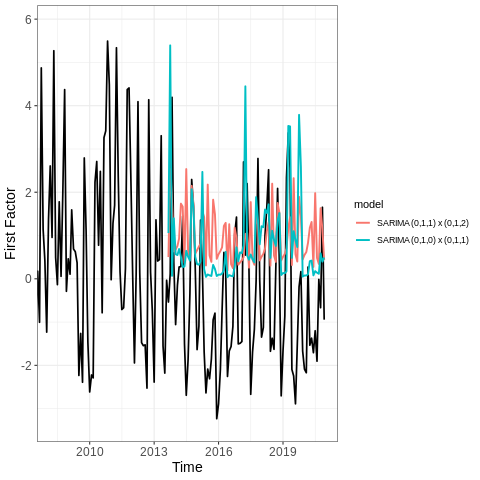

In [215]:
%%R
ggplot(DataFac2, aes(x = Time, y = Fac1)) +
  geom_line(linewidth = 0.8) +
   geom_line(data = df_forecast_f1, aes(x = Time, y = value, color = model),linewidth = 0.9) +
  coord_cartesian(xlim = c(min(df_forecast_f1$Time) - 2000, max(df_forecast_f1$Time)))+
  scale_x_date(date_breaks = "3 years", date_labels = "%Y") +
  labs(x = "Time", y = "First Factor") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

In [202]:
%%R
# sarima(fac1, p = 1, d = 0, q = 0, P = 2, D = 0, Q = 0, S = 12,
ourCall_f2 <- "forecast::forecast(Arima(y = data, c(1, 0, 0), seasonal = list(order = c(2, 0, 0), period = 12), lambda = 0), h = h)"
ourValue_f2 <- "mean"
returnedValues_f2 <- ro(data = DataFac2$Fac2, h=1, origins=88, ourCall_f2, ourValue_f2)
sqrt(mean((returnedValues_f2$holdout - returnedValues_f2$mean)^2))

[1] 0.8145683


In [203]:
%%R
#sarima(fac1, p = 0, d = 0, q = 0, P = 1, D = 1, Q = 0, S = 12,
ourCall_f2_m2 <- "forecast::forecast(Arima(y = data, c(0, 0, 0), seasonal = list(order = c(1, 1, 0), period = 12), lambda = 0), h = h)"
ourValue_f2 <- "mean"
returnedValues_f2_m2 <- ro(data = DataFac2$Fac2, h=1, origins=88, ourCall_f2_m2, ourValue_f2)
sqrt(mean((returnedValues_f2_m2$holdout - returnedValues_f2_m2$mean)^2))

[1] 0.8978852


In [208]:
%%R
df_forecast_f2 <- data.frame(
  Time = tail(DataFac2$Time, length(returnedValues_f2$mean)),
  mean = as.numeric(returnedValues_f2$mean),
  mean2 = as.numeric(returnedValues_f2_m2$mean)) %>%
  pivot_longer(cols = c(mean, mean2),names_to = "model",values_to = "value")

df_forecast_f2$model <- factor(
  df_forecast_f2$model,
  levels = c("mean", "mean2"),
  labels = c("SARIMA (1,0,0) x (2,0,0)", "SARIMA (0,0,0) x (1,1,0)")
)

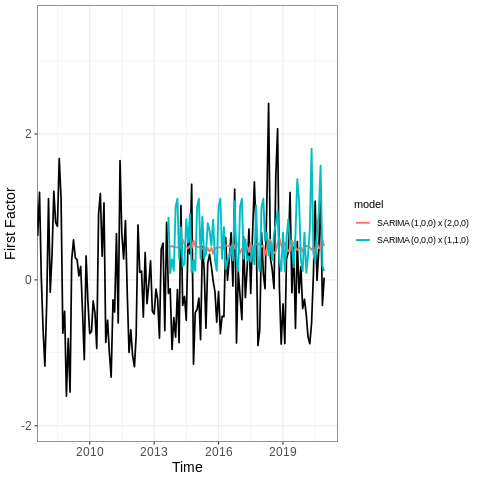

In [210]:
%%R
ggplot(DataFac2, aes(x = Time, y = Fac2)) +
  geom_line(linewidth = 0.8) +
  geom_line(data = df_forecast_f2,
    aes(x = Time, y = value, color = model),
    linewidth = 0.9)+
  coord_cartesian(xlim = c(min(df_forecast_f2$Time) - 2000, max(df_forecast_f2$Time)))+
  scale_x_date(date_breaks = "3 years", date_labels = "%Y") +
  labs(x = "Time", y = "First Factor") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

In [254]:
%%R
head(X2[393:480,mun])

[1]  61.5 114.6 118.8  29.1  33.7 148.4


In [265]:
%%R
mun <- 1 # Bucaramanga
Fac_hat = data.frame(f1 = df_forecast_f1$value[df_forecast_f1$model == 'SARIMA (0,1,0) x (0,1,1)'],
                     f2 = df_forecast_f2$value[df_forecast_f2$model == 'SARIMA (1,0,0) x (2,0,0)'])
Chi_hat <- as.matrix(Fac_hat) %*% t(Load)

Data_hat <- data.frame(Time = Data2$Date[Data2$Date > as.Date('2013-08-01')],
                       x1 = sX2[393:480,mun], x2 = Chi_hat[,mun]) %>%
  gather(key = "Type", value = "Value", 2:3)

In [269]:
%%R
Data_hat_ <- data.frame(Time = Data2$Date[Data2$Date > as.Date('2013-08-01')],
                       x1 = sX2[393:480,mun], x2 = Chi_hat[,mun])
sqrt(mean((Data_hat_$x1 - Data_hat_$x2)^2))

[1] 1.122436


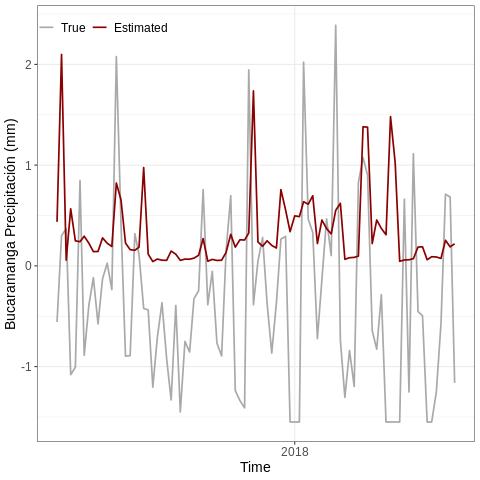

In [266]:
%%R
# plot True (ts scaled) vs Estimated (x2: Chi = Fac %*% t(Load))
ggplot(Data_hat, aes(x = Time, y = Value, colour = Type)) +
  geom_line(linewidth = 0.8) +
  scale_x_date(date_breaks = "5 years", date_labels = "%Y") +
  scale_colour_manual(values = c("darkgrey", "darkred"),
                      labels = c("True", "Estimated")) +
  labs(x = "Time", y = "Bucaramanga Precipitación (mm)") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 12),
        legend.title = element_blank(),
        legend.text = element_text(size = 12),
        legend.position = "inside",
        legend.position.inside = c(.15, .95),
        legend.background = element_blank(),
        legend.key = element_blank(),
        legend.direction = "horizontal")

In [222]:
%%R
# Common components
mun <- 1 # Bucaramanga
Fac2 <- X2 %*% Load
Chi2 <- Fac2 %*% t(Load)
x2 <- ts(X2[,mun], start = c(1981, 1), end = c(2020, 12), frequency = 12)
#'data.frame':	408 obs. of  3 variables:
#$ Time : Date, format: "2008-01-31" "2008-02-29" ...
#$ Type : chr  "x1" "x1" "x1" "x1" ...
#$ Value: num  0.0805 -0.0484 -0.3707 0.016 -1.0796 ...
DataChi2 <- data.frame(Time = Data2$Date, x1 = X2[,mun], x2 = Chi2[,mun]) %>%
  gather(key = "Type", value = "Value", 2:3)

In [216]:
%%R
mun = c("Bucaramanga", "Cúcuta", "Ibagué",  "Medellín", "Manizales", "Bogotá")

DataLoad <- data.frame(Mun = colnames(Data)[-1], MunName = mun,order = 1:6,
                       Load1 = Load[,1], Load2 = Load[,2])

DataLoad$MunName <- factor(DataLoad$MunName,
                           levels = DataLoad$MunName[order(DataLoad$order)])
DataLoad

          Mun     MunName order     Load1       Load2
1 Bucaramanga Bucaramanga     1 0.3833104  0.06819511
2      Cúcuta      Cúcuta     2 0.3364405 -0.24440586
3      Ibagué      Ibagué     3 0.4208365  0.16980850
4    Medellín    Medellín     4 0.3732449  0.81961848
5   Manizales   Manizales     5 0.4641937 -0.18966888
6      Bogotá      Bogotá     6 0.4560592 -0.44612950


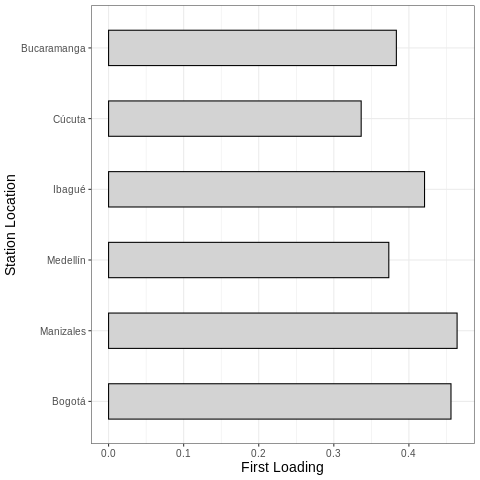

In [217]:
%%R
ggplot(DataLoad, aes(x = fct_reorder(MunName, order),
                     y = Load1)) +
  geom_col(width = 0.5, color = "black", fill = "lightgrey") +
  #geom_bar(stat = "identity", width = 0.5, color = "black", fill = "lightgrey") +
  coord_flip() +
  scale_x_discrete(limits = rev)+
  labs(x = "Station Location", y = "First Loading") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 10))

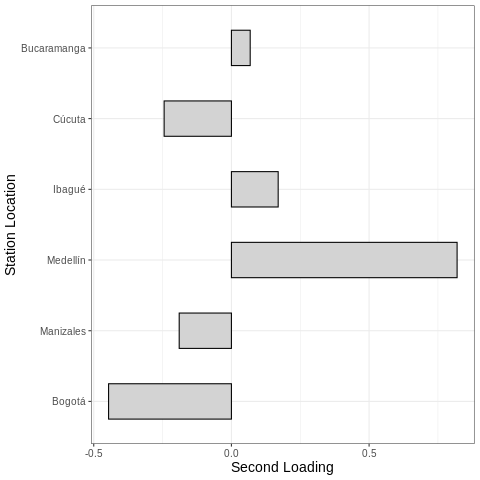

In [218]:
%%R
ggplot(DataLoad, aes(x = fct_reorder(MunName, order),
                     y = Load2)) +
  geom_col(width = 0.5, color = "black", fill = "lightgrey") +
  #geom_bar(stat = "identity", width = 0.5, color = "black", fill = "lightgrey") +
  coord_flip() +
  scale_x_discrete(limits = rev)+
  labs(x = "Station Location", y = "Second Loading") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 10))

In [ ]:
%%R
# Common components
mun <- 1 # Bucaramanga

x <- ts(X[,mun], start = c(1981, 1), end = c(2013, 06), frequency = 12)

#'data.frame':	408 obs. of  3 variables:
#$ Time : Date, format: "2008-01-31" "2008-02-29" ...
#$ Type : chr  "x1" "x1" "x1" "x1" ...
#$ Value: num  0.0805 -0.0484 -0.3707 0.016 -1.0796 ...
DataChi <- data.frame(Time = Data$Date, x1 = X[,mun], x2 = Chi[,mun]) %>%
  gather(key = "Type", value = "Value", 2:3)

head(DataChi)
# 2:3 A selection of columns. If empty, all variables are selected.
# x1: ts original (tranf. scaled)
# x2: Fac %*% t(Load), donde Fac = X %*% Load

        Time Type       Value
1 1981-01-01   x1  0.03596270
2 1981-02-01   x1  0.04078575
3 1981-03-01   x1 -0.26788993
4 1981-04-01   x1  0.44592260
5 1981-05-01   x1  1.37194966
6 1981-06-01   x1 -0.71964967


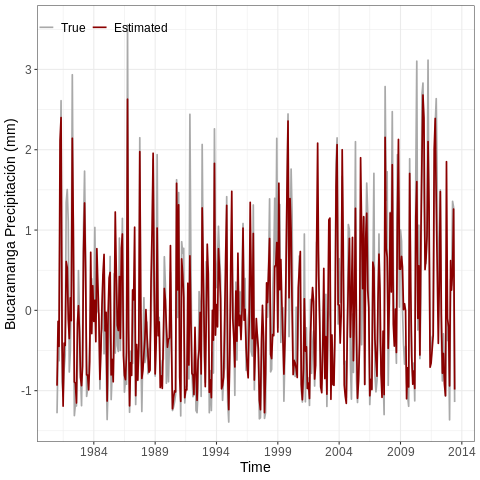

In [ ]:
%%R
# plot True (ts scaled) vs Estimated (x2: Chi = Fac %*% t(Load))
ggplot(DataChi, aes(x = Time, y = Value, colour = Type)) +
  geom_line(linewidth = 0.8) +
  scale_x_date(date_breaks = "5 years", date_labels = "%Y") +
  scale_colour_manual(values = c("darkgrey", "darkred"),
                      labels = c("True", "Estimated")) +
  labs(x = "Time", y = "Bucaramanga Precipitación (mm)") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 12),
        legend.title = element_blank(),
        legend.text = element_text(size = 12),
        legend.position = "inside",
        legend.position.inside = c(.15, .95),
        legend.background = element_blank(),
        legend.key = element_blank(),
        legend.direction = "horizontal")

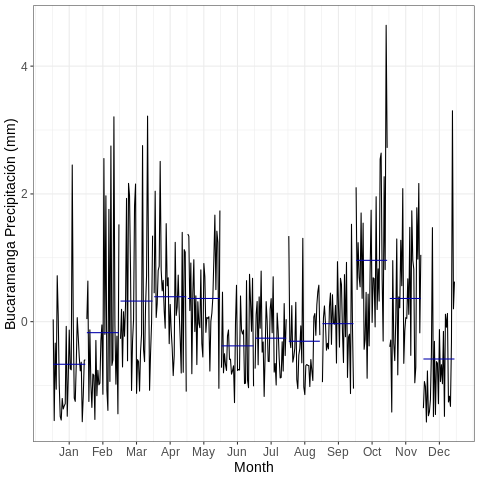

In [ ]:
%%R
# gráfico de Temp (scaled) subseries
ggsubseriesplot(x) +
  labs(y = "Bucaramanga Precipitación (mm)") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

In [ ]:
%%R
mun <- 6 # "Bogotá"

x <- ts(X[,mun], start = c(1981, 1), end = c(2013, 06), frequency = 12)

DataChi <- data.frame(Time = Data$Date, x1 = X[,mun], x2 = Chi[,mun]) %>%
  gather(key = "Type", value = "Value", 2:3)
head(DataChi)

        Time Type      Value
1 1981-01-01   x1 -1.2813344
2 1981-02-01   x1 -0.5095426
3 1981-03-01   x1 -0.6275814
4 1981-04-01   x1  1.3790771
5 1981-05-01   x1  2.6103119
6 1981-06-01   x1 -0.8908986


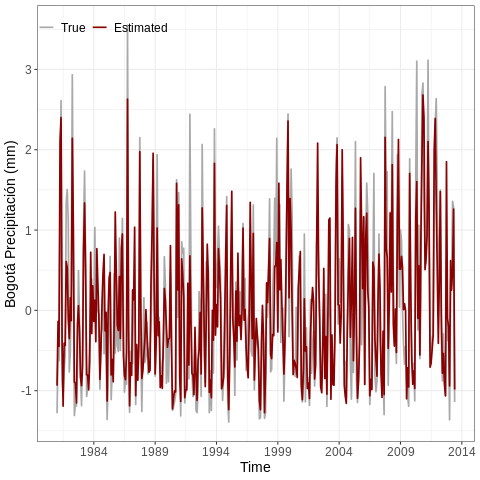

In [ ]:
%%R
# plot True (ts scaled) vs Estimated (x2: Chi = Fac %*% t(Load))
ggplot(DataChi, aes(x = Time, y = Value, colour = Type)) +
  geom_line(linewidth = 0.8) +
  scale_x_date(date_breaks = "5 years", date_labels = "%Y") +
  scale_colour_manual(values = c("darkgrey", "darkred"),
                      labels = c("True", "Estimated")) +
  labs(x = "Time", y = "Bogotá Precipitación (mm)") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 12),
        legend.title = element_blank(),
        legend.text = element_text(size = 12),
        legend.position = "inside",
        legend.position.inside = c(.15, .95),
        legend.background = element_blank(),
        legend.key = element_blank(),
        legend.direction = "horizontal")

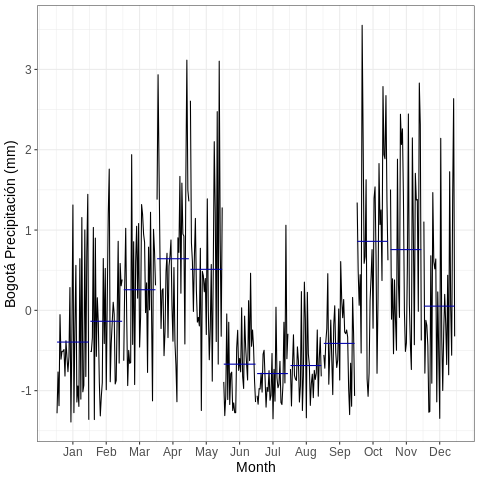

In [ ]:
%%R
ggsubseriesplot(x) +
  labs(y = "Bogotá Precipitación (mm)") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

# [Chaves, D. O., Chiann, C., & Morettin, P. A. (2025). A nonstationary seasonal Dynamic Factor Model: an application to temperature time series from the state of Minas Gerais.](https://arxiv.org/abs/2510.15667)

## 1. Datos

In [ ]:
%%R
#Data <- readRDS("ImputedData.RDS")
Data <- readRDS("/content/drive/MyDrive/SeasonalDFM_TemperatureMG_2025/ImputedData.RDS")
print(n_distinct(Data$StationCode)) # 43 sttns
print(range(Data$Time)) # 2008-01 a 2024-12 (mensual)
print(n_distinct(Data$Time)) # 204 meses (17 años)
range(Data$Temp) # 9.8 a 29.8

[1] 43
[1] "2008-01-31" "2024-12-31"
[1] 204
[1]  9.8 29.8


In [ ]:
%%R
#'data.frame':	8772 obs. of  4 variables:
#$ StationCode: chr  "A502" "A502" "A502" "A502" ...
#$ Local      : chr  "BARBACENA" "BARBACENA" "BARBACENA" "BARBACENA" ...
#$ Time       : Date, format: "2008-01-31" "2008-02-29" ...
#$ Temp       : num  19.4 20.3 19.7 19.4 16.6 15.9 15.3 17.6 17.2 19.4 ...
Data <- Data %>%
  mutate(Mun = Local) %>%
  mutate(Mun = str_replace_all(Mun, c("MONTE VERDE" = "CAMANDUCAIA",
                                      "MOCAMBINHO" = "JAIBA")))

# cada fila  i:mes ,columna j:sttns
Data <- Data %>%
  filter(Local != "ESPINOSA") %>%
  dplyr::select(Mun, Time, Temp) %>%
  spread(key = Mun, value = Temp)

# 'data.frame':	204 obs. of  43 variables:
X <- as.matrix(Data[,2:43]) # elimina fila del mes

# Scaling data
X <- scale(X) # escala los datos (x_{ij} - \bar{x}_{j})

In [ ]:
%%R
head(X[,1:6])

     AGUAS VERMELHAS   ALMENARA  BARBACENA BELO HORIZONTE - PAMPULHA
[1,]       0.4720097  0.2233843  0.3869762                 0.1017265
[2,]       0.6173885  0.5318976  0.8367412                 0.6492783
[3,]       0.3266308  0.1205465  0.5368979                 0.2659921
[4,]       0.4235500  0.4290599  0.3869762                 0.3207473
[5,]      -0.9333190 -0.8564124 -1.0122929                -1.1576426
[6,]      -1.5148343 -1.6791146 -1.3621102                -1.3219081
         BURITIS CAMANDUCAIA
[1,]  0.08047339   0.5465656
[2,] -0.04842282   0.7901913
[3,] -0.37066334   0.4247527
[4,]  0.01602529   0.0999184
[5,] -1.07959250  -1.4836489
[6,] -1.40183302  -1.2806275


## 2. Número de factores

In [ ]:
%%R
S <- 12
nObs <- nrow(X) # 204 meses

EVMatrix <- t(sapply(0:36, FUN = function(h){

  # rezagos
  Xt <- X[(h+1):nObs,]
  Xt_h <- X[1:(nObs-h),]

  # Sample generalized autocovariance of lag h

  Ch <- ((S/nObs)^2) * (t(Xt) %*% Xt_h)


  # Five largest absolute eigenvalues

  abs(eigen(Ch)$values)[1:5]
}))



# Eigenvalues figure

EVData <- data.frame(Lag = 0:36)

# 185 filas (37 lags * 5 EV), 3 cols
# Valor C_h combinación lag-EV
EVData <- cbind(EVData, EVMatrix) %>%
  gather(key = "EV", value = "Value", 2:6)

#'data.frame':	185 obs. of  3 variables:
#$ Lag  : int  0 1 2 3 4 5 6 7 8 9 ...
#$ EV   : chr  "1" "1" "1" "1" ...
#$ Value: num  26.06 18.91 6.72 3.96 8.42 ...

In [ ]:
%%R
head(EVData)

  Lag EV     Value
1   0  1 26.057228
2   1  1 18.911698
3   2  1  6.723358
4   3  1  3.959506
5   4  1  8.416666
6   5  1 12.991514


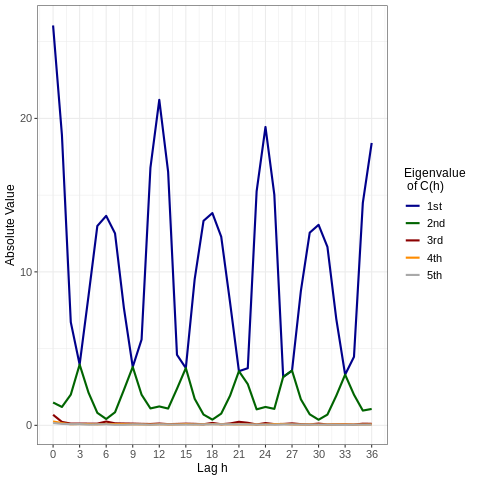

In [ ]:
%%R
ggplot(EVData, aes(x = Lag, y = Value, colour = EV)) +
  geom_line(linewidth = 1) +
  scale_x_continuous(breaks = seq(0, 36, by = 3)) +
  scale_color_manual(values = c("darkblue", "darkgreen", "darkred",
                                "darkorange", "darkgrey"),
                     labels = c("1st", "2nd", "3rd", "4th", "5th")) +
  labs(y = "Absolute Value", x = "Lag h", colour = "Eigenvalue \n of C(h)") +
  theme_bw() +
  theme(axis.title = element_text(size = 12),
        legend.title = element_text(size = 12),
        axis.text = element_text(size = 11),
        legend.text = element_text(size = 11))

In [ ]:
%%R
rm(S, nObs, EVMatrix, EVData)

## 3. Estimación - Factores y Cargas

In [ ]:
%%R
# Sample generalized autocovariance of lag 12

S <- 12
nObs <- nrow(X) #204 meses
h <- 12

Xt <- X[(h+1):nObs,]
Xt_h <- X[1:(nObs-h),]

# matriz de autocovarianza muestral generalizada para rezago h
Ch <- ((S/nObs)^2) * (t(Xt) %*% Xt_h)

print(range(Ch)) # 0.2548381 0.6055674
print(head(Ch[,1:6]))
# 42 sttns x 42 sttns
#num [1:42, 1:42] 0.556 0.533 0.53 0.508 0.361 ...
#- attr(*, "dimnames")=List of 2
#..$ : chr [1:42] "AGUAS VERMELHAS" "ALMENARA" "BARBACENA" "BELO HORIZONTE - PAMPULHA" ...
#..$ : chr [1:42] "AGUAS VERMELHAS" "ALMENARA" "BARBACENA" "BELO HORIZONTE - PAMPULHA" ...

rm(S, nObs, h, Xt, Xt_h)

[1] 0.2548381 0.6055674
                          AGUAS VERMELHAS  ALMENARA BARBACENA
AGUAS VERMELHAS                 0.5561413 0.5226547 0.5393183
ALMENARA                        0.5328132 0.5110220 0.5258014
BARBACENA                       0.5297122 0.5191723 0.5501669
BELO HORIZONTE - PAMPULHA       0.5075352 0.4824808 0.5096791
BURITIS                         0.3611408 0.3042706 0.3339673
CAMANDUCAIA                     0.5605982 0.5432873 0.5667030
                          BELO HORIZONTE - PAMPULHA   BURITIS CAMANDUCAIA
AGUAS VERMELHAS                           0.5208687 0.3737946   0.5647113
ALMENARA                                  0.4949099 0.3344952   0.5477787
BARBACENA                                 0.5125675 0.3447188   0.5614292
BELO HORIZONTE - PAMPULHA                 0.5094645 0.4153161   0.5297421
BURITIS                                   0.4041670 0.4693100   0.3717761
CAMANDUCAIA                               0.5402638 0.3850461   0.5836494


In [ ]:
%%R
# Loadings

# eigenvectors de Ch (de acuerdo al gráfico se toman dos factores)
Load <- Re(eigen(Ch)$vectors[,1:2])

print(Load)
rm(Ch)

# Factors
Fac <- X %*% Load
#  num [1:204, 1:2] 2.062 3.247 1.469 0.891 -8.091 ... #str(Fac)
print(head(Fac))
# Common components

Chi <- Fac %*% t(Load)
colnames(Chi) <- colnames(X)
print(head(Chi[,1:6]))
#num [1:204, 1:42] 0.427 0.707 0.432 0.288 -1.164 ...
#- attr(*, "dimnames")=List of 2
#..$ : NULL
#..$ : chr [1:42] "AGUAS VERMELHAS" "ALMENARA" "BARBACENA" "BELO HORIZONTE - PAMPULHA" ...

           [,1]         [,2]
 [1,] 0.1585110  0.116491774
 [2,] 0.1505896  0.168405769
 [3,] 0.1540563  0.177211966
 [4,] 0.1539568  0.004725503
 [5,] 0.1241241 -0.333902332
 [6,] 0.1630965  0.138535924
 [7,] 0.1580305 -0.179608526
 [8,] 0.1596566  0.113682458
 [9,] 0.1545332  0.089414368
[10,] 0.1590322 -0.141042498
[11,] 0.1604011 -0.051851259
[12,] 0.1520561  0.092176574
[13,] 0.1611762 -0.054845663
[14,] 0.1610915 -0.024278432
[15,] 0.1598119  0.089093745
[16,] 0.1606549  0.108804892
[17,] 0.1475650 -0.188027264
[18,] 0.1596016 -0.187934524
[19,] 0.1351023 -0.138582239
[20,] 0.1407292 -0.166027855
[21,] 0.1463045  0.223637564
[22,] 0.1480481  0.235548180
[23,] 0.1683732  0.099444775
[24,] 0.1434622 -0.232885165
[25,] 0.1446145 -0.114861094
[26,] 0.1532392  0.206271959
[27,] 0.1569803  0.077990711
[28,] 0.1614345  0.130672167
[29,] 0.1646161 -0.067736992
[30,] 0.1637021 -0.098551744
[31,] 0.1586306 -0.113499132
[32,] 0.1583602  0.054947282
[33,] 0.1559812 -0.165987450
[34,] 0.151273

## 4. Modelos Factores

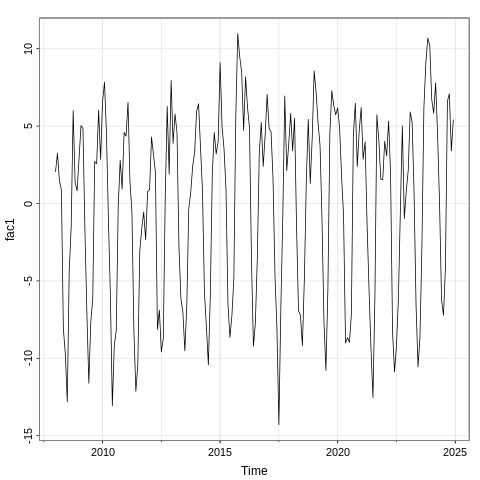

In [ ]:
%%R
# First factor
fac1 <- ts(Fac[,1], start = c(2008, 1), end = c(2024, 12), frequency = 12)

tsplot(fac1) # gráfico factor 1

In [ ]:
%%R
# test Box-Ljung (correlación/independencia del factor 1)
Box.test(fac1, lag = 24, type = "Ljung-Box") # p-value < 0.05 -> R. H0 (indep.)


	Box-Ljung test

data:  fac1
X-squared = 1188, df = 24, p-value < 2.2e-16



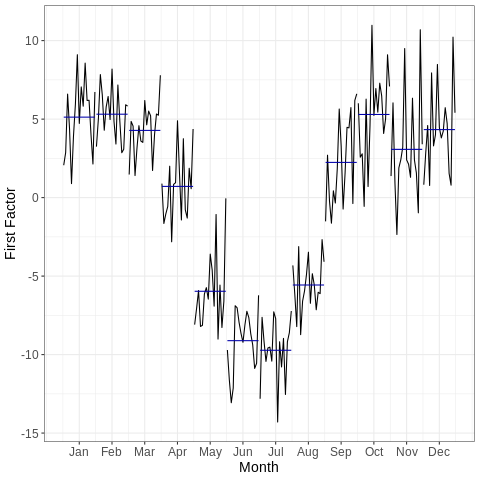

In [ ]:
%%R
# El factor 1 tiene media no constante (no-estacionariedad)
ggsubseriesplot(fac1) +
  labs(y = "First Factor") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

[1] 1


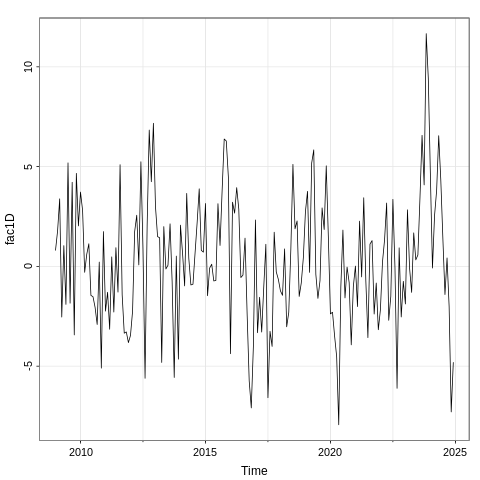

In [ ]:
%%R
print(nsdiffs(fac1)) # núm de diff estacional para volver  remover la comp estacional (volver la serie estacionaria)

fac1D <- diff(fac1, lag = 12) # diff estacional

tsplot(fac1D)

In [ ]:
%%R
# test Kwiatkowski et al. Unit Root Tes (chequea raíz unitaria H0: Estacionariedad)
summary(ur.kpss(fac1D)) # estadistico_prueba < valor_critico -> No rechaza H0 (concluye estacionariedad)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 4 lags. 

Value of test-statistic is: 0.07 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



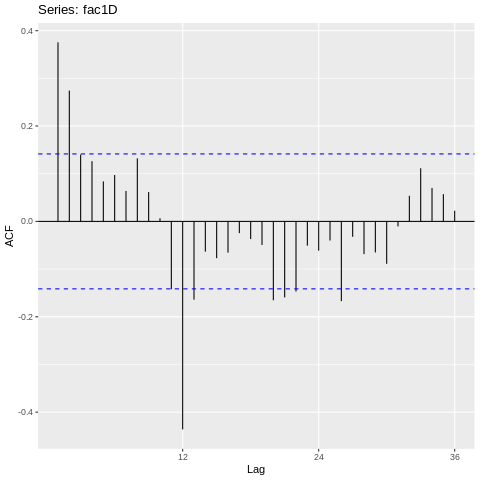

In [ ]:
%%R
ggAcf(fac1D, lag.max = 36) # función de Autocorrelación
# q = 2 y Q = 1

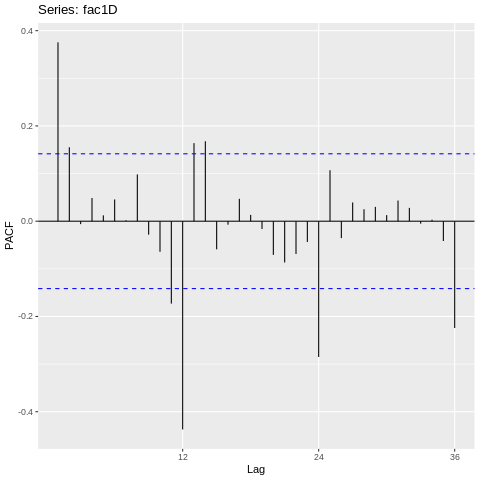

In [ ]:
%%R
ggPacf(fac1D, lag.max = 36) # función de Autocorrelación parcial
# p= 2, P = 3

In [ ]:
%%R
Box.test(fac1D, lag = 24, type = "Ljung-Box") # p-value < 0.05 -> R. H0 (indep.)


	Box-Ljung test

data:  fac1D
X-squared = 128.47, df = 24, p-value = 3.331e-16



initial  value 1.171430 
iter   2 value 0.912790
iter   3 value 0.878725
iter   4 value 0.848002
iter   5 value 0.837951
iter   6 value 0.833279
iter   7 value 0.831141
iter   8 value 0.830649
iter   9 value 0.830620
iter  10 value 0.830609
iter  11 value 0.830608
iter  12 value 0.830607
iter  12 value 0.830607
iter  12 value 0.830607
final  value 0.830607 
converged
initial  value 0.814156 
iter   2 value 0.807318
iter   3 value 0.806280
iter   4 value 0.806114
iter   5 value 0.806107
iter   6 value 0.806106
iter   6 value 0.806106
iter   6 value 0.806106
final  value 0.806106 
converged
<><><><><><><><><><><><><><>
 
Coefficients: 
     Estimate     SE  t.value p.value
ar1    0.3452 0.0706   4.8856  0.0000
ar2    0.2279 0.0704   3.2395  0.0014
sma1  -0.8795 0.0653 -13.4670  0.0000

sigma^2 estimated as 4.565738 on 189 degrees of freedom 
 
AIC = 4.491756  AICc = 4.492421  BIC = 4.559621 
 


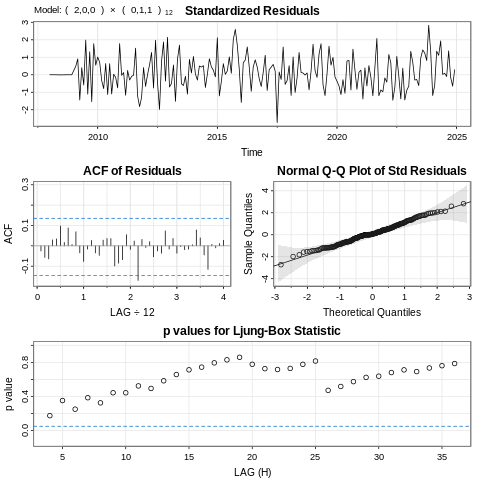

In [ ]:
%%R
# ajusta un modelo SARIMA, con los ordenes sugeridos por ACF para p=2 y PACF para q, 1 diff estacional de rezago S=12
# el orden Q=1 de acuerdo a qué???

SARIMA <- sarima(fac1, p = 2, d = 0, q = 0, P = 0, D = 1, Q = 1, S = 12,
                 no.constant = T)

In [ ]:
%%R
Box.test(SARIMA$fit$residuals, lag = 24, type = "Ljung-Box") # p-value > 0.05 -> No R. H0 (concluye indep.)


	Box-Ljung test

data:  SARIMA$fit$residuals
X-squared = 15.875, df = 24, p-value = 0.8925



Bandwidth: 0.215 | Degrees of Freedom: 7.31 | split taper: 0% 


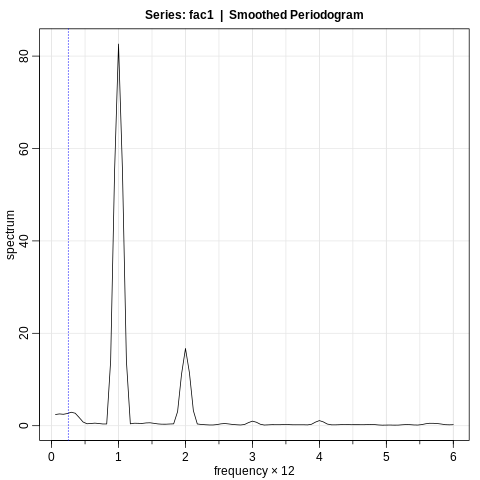

In [ ]:
%%R
# estimación espectral
kd <- kernel("modified.daniell", m = c(1,1))
PSmoo <- mvspec(fac1, fast = F, detrend = F, kernel = kd)
abline(v = 1/4, col = "blue", lty = 3)

rm(fac1, fac1D, SARIMA, kd, PSmoo)

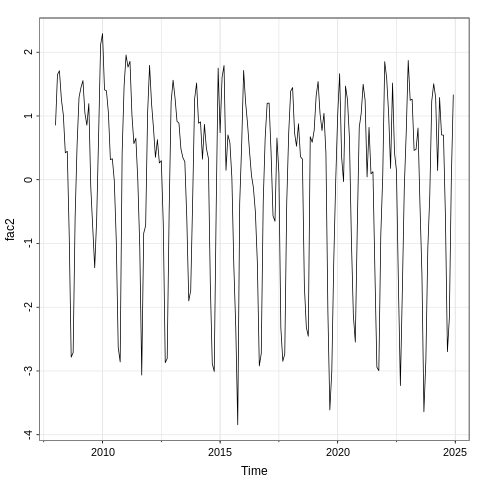

In [ ]:
%%R
# Second factor
fac2 <- ts(Fac[,2], start = c(2008, 1), end = c(2024, 12), frequency = 12)

tsplot(fac2)

In [ ]:
%%R
Box.test(fac2, lag = 24, type = "Ljung-Box") # p-value < 0.05 (R. H0: indep)


	Box-Ljung test

data:  fac2
X-squared = 1071.3, df = 24, p-value < 2.2e-16



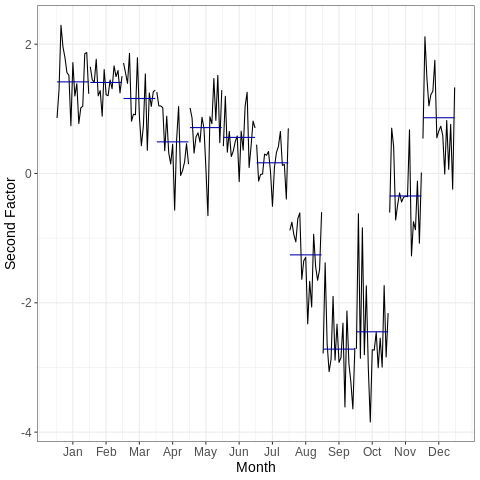

In [ ]:
%%R
# El factor 2 tiene media no constante (no-estacionariedad)
ggsubseriesplot(fac2) +
  labs(y = "Second Factor") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

[1] 1


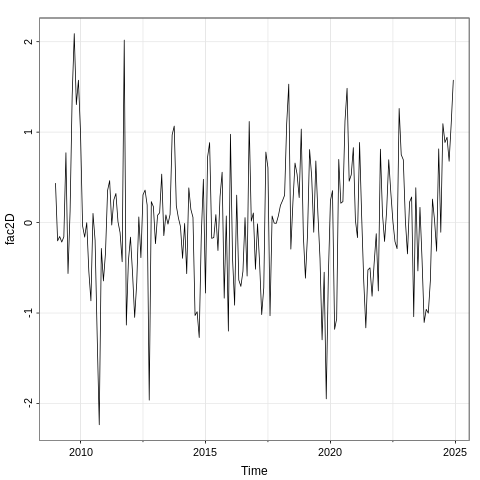

In [ ]:
%%R
print(nsdiffs(fac2)) # núm de diff estacional para volver  remover la comp estacional (volver la serie estacionaria)

fac2D <- diff(fac2, lag = 12) # diff estacional

tsplot(fac2D) # se ve estacionario

In [ ]:
%%R
summary(ur.kpss(fac2D)) # estadístico = 0.0755 < CValor crítico (No R. H0, concluye estacionariedad)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 4 lags. 

Value of test-statistic is: 0.0755 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



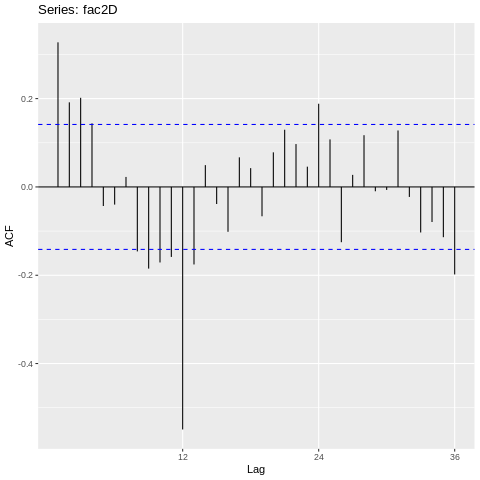

In [ ]:
%%R
ggAcf(fac2D, lag.max = 36) # rezagos con ACf dentro de las bandas, excepto rezago = 12

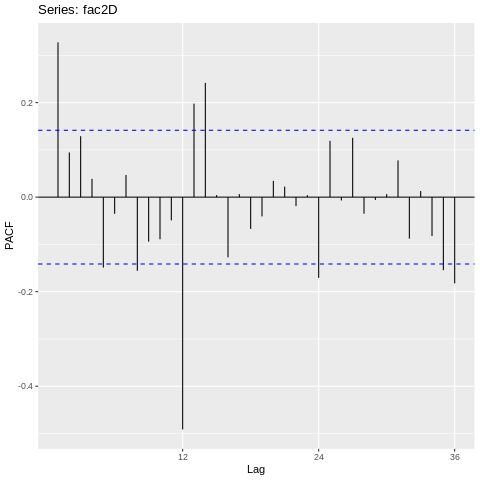

In [ ]:
%%R
ggPacf(fac2D, lag.max = 36) # rezagos con PACf dentro de las bandas, excepto rezago = 12

In [ ]:
%%R
Box.test(fac2D, lag = 24, type = "Ljung-Box") # p-value < 0.05 (R. H0, concluye no indep.)


	Box-Ljung test

data:  fac2D
X-squared = 153.03, df = 24, p-value < 2.2e-16



initial  value -0.335226 
iter   2 value -0.621981
iter   3 value -0.641548
iter   4 value -0.646515
iter   5 value -0.655320
iter   6 value -0.658220
iter   7 value -0.658618
iter   8 value -0.659048
iter   9 value -0.659056
iter  10 value -0.659056
iter  10 value -0.659056
iter  10 value -0.659056
final  value -0.659056 
converged
initial  value -0.655534 
iter   2 value -0.655649
iter   3 value -0.655653
iter   4 value -0.655653
iter   4 value -0.655653
iter   4 value -0.655653
final  value -0.655653 
converged
<><><><><><><><><><><><><><>
 
Coefficients: 
     Estimate     SE  t.value p.value
ar1    0.3394 0.0686   4.9464       0
sma1  -0.8076 0.0624 -12.9457       0

sigma^2 estimated as 0.252107 on 190 degrees of freedom 
 
AIC = 1.557821  AICc = 1.558152  BIC = 1.60872 
 


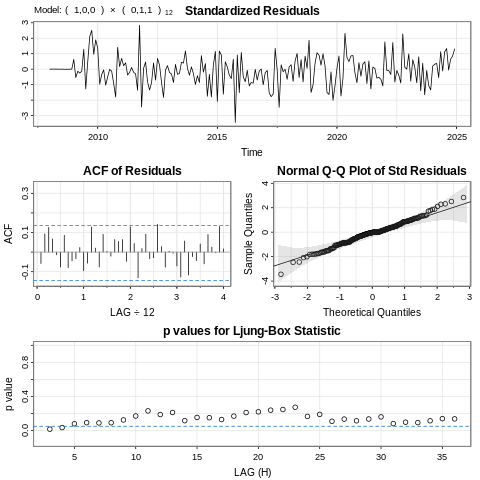

In [ ]:
%%R
# ajusta un modelo SARIMA, con los ordenes sugeridos por ACF para p=1 (aunque sufiere hasta p=3)
# y PACF para q, 1 diff estacional de rezago S=12
# el orden Q=1 de acuerdo a qué???
SARIMA <- sarima(fac2, p = 1, d = 0, q = 0, P = 0, D = 1, Q = 1, S = 12,
                 no.constant = T)

In [ ]:
%%R
Box.test(SARIMA$fit$residuals, lag = 24, type = "Ljung-Box") # p-value > 0.05 (No R. H0, concluye indep.)


	Box-Ljung test

data:  SARIMA$fit$residuals
X-squared = 28.296, df = 24, p-value = 0.2478



Bandwidth: 0.215 | Degrees of Freedom: 7.31 | split taper: 0% 


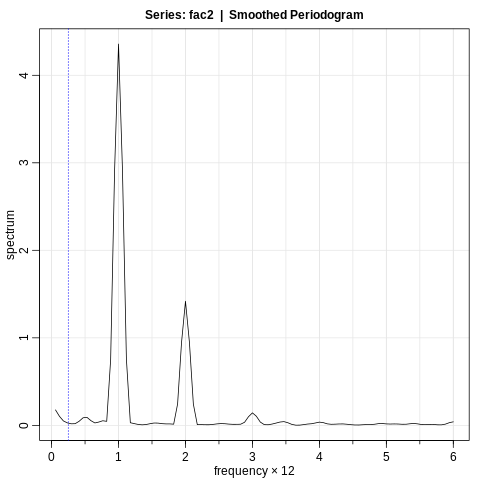

In [ ]:
%%R
kd <- kernel("modified.daniell", m = c(1,1))
PSmoo <- mvspec(fac2, fast = F, detrend = F, kernel = kd) # periodograma: densidad espectral
abline(v = 1/4, col = "blue", lty = 3)

rm(fac2, fac2D, SARIMA, kd, PSmoo)

## 5. Visualización - Factores y Cargas

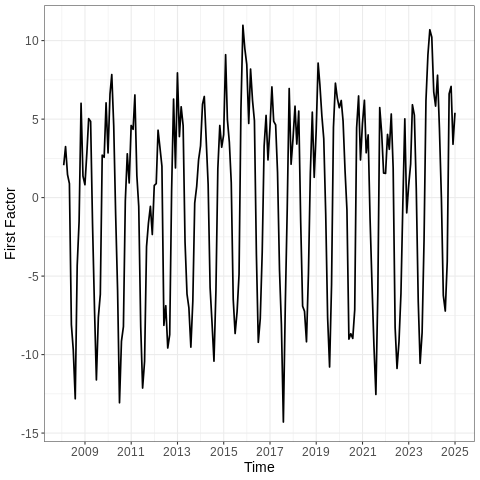

In [ ]:
%%R
# Factors
DataFac <- data.frame(Time = Data$Time, Fac1 = Fac[,1], Fac2 = Fac[,2])
#'data.frame':	204 obs. of  3 variables:
#$ Time: Date, format: "2008-01-31" "2008-02-29" ...
#$ Fac1: num  2.062 3.247 1.469 0.891 -8.091 ...
#$ Fac2: num  0.857 1.65 1.709 1.261 1.014 ...

# Gráfico ts de Factor 1
ggplot(DataFac, aes(x = Time, y = Fac1)) +
  geom_line(linewidth = 0.8) +
  scale_x_date(date_breaks = "2 years", date_labels = "%Y") +
  labs(x = "Time", y = "First Factor") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

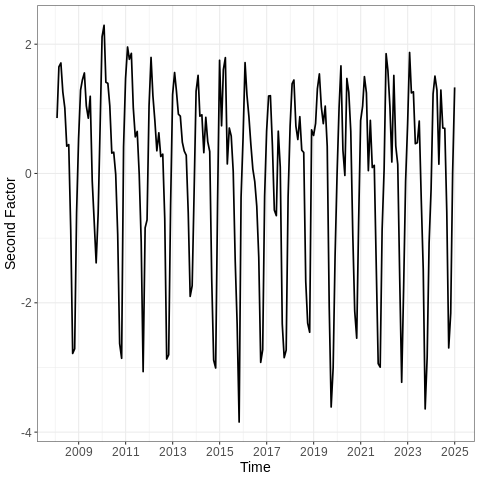

In [ ]:
%%R
# Gráfico ts de Factor 2
ggplot(DataFac, aes(x = Time, y = Fac2)) +
  geom_line(linewidth = 0.8) +
  scale_x_date(date_breaks = "2 years", date_labels = "%Y") +
  labs(x = "Time", y = "Second Factor") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

In [ ]:
%%R
# Loadings

mun <- c("Águas Vermelhas", "Almenara", "Barbacena", "Belo Horizonte",
         "Buritis", "Camanducaia", "Campina Verde", "Capelinha", "Caratinga",
         "Conceição das Alagoas", "Curvelo", "Diamantina", "Dores do Indaiá",
         "Formiga", "Governador Valadares", "Guanhães", "Guarda-Mor",
         "Ituiutaba", "Jaíba", "João Pinheiro", "Juiz de Fora", "Mantena",
         "Maria da Fé", "Montalvânia", "Montes Claros", "Muriaé", "Ouro Branco",
         "Passa Quatro", "Passos", "Patrocínio", "Pirapora",
         "Rio Pardo de Minas", "Sacramento", "Salinas", "São João del Rei",
         "Serra dos Aimorés", "Timóteo", "Três Marias", "Uberlândia", "Unaí",
         "Varginha", "Viçosa")

#'data.frame':	42 obs. of  4 variables:
#$ Mun    : chr  "AGUAS VERMELHAS" "ALMENARA" "BARBACENA" "BELO HORIZONTE - PAMPULHA" ...
#$ MunName: chr  "Águas Vermelhas" "Almenara" "Barbacena" "Belo Horizonte" ...
#$ Load1  : num  0.159 0.151 0.154 0.154 0.124 ...
#$ Load2  : num  0.11649 0.16841 0.17721 0.00473 -0.3339 ...
DataLoad <- data.frame(Mun = colnames(Data)[-1], MunName = mun,
                       Load1 = Load[,1], Load2 = Load[,2])

head(DataLoad)

                        Mun         MunName     Load1        Load2
1           AGUAS VERMELHAS Águas Vermelhas 0.1585110  0.116491774
2                  ALMENARA        Almenara 0.1505896  0.168405769
3                 BARBACENA       Barbacena 0.1540563  0.177211966
4 BELO HORIZONTE - PAMPULHA  Belo Horizonte 0.1539568  0.004725503
5                   BURITIS         Buritis 0.1241241 -0.333902332
6               CAMANDUCAIA     Camanducaia 0.1630965  0.138535924


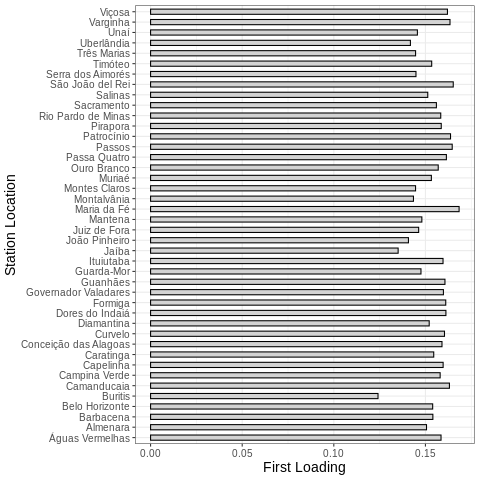

In [ ]:
%%R
# para cada estación "cargas/loadings" positivas al 1er Loading
ggplot(DataLoad, aes(MunName, Load1)) +
  geom_bar(stat = "identity", width = 0.5, color = "black", fill = "lightgrey") +
  coord_flip() +
  labs(x = "Station Location", y = "First Loading") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 10))

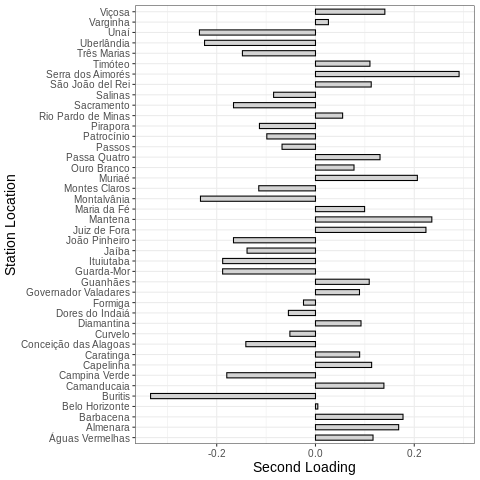

In [ ]:
%%R
# para cada estación "cargas/loadings" positivas/negativas al 2do Loading
ggplot(DataLoad, aes(MunName, Load2)) +
  geom_bar(stat = "identity", width = 0.5, color = "black", fill = "lightgrey") +
  coord_flip() +
  labs(x = "Station Location", y = "Second Loading") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 10))

In [ ]:
%%R
# Map of the second loading
#'data.frame':	42 obs. of  3 variables:
#$ Mun    : chr  "AGUAS VERMELHAS" "ALMENARA" "BARBACENA" "BELO HORIZONTE - PAMPULHA" ...
#$ Load2  : num  0.11649 0.16841 0.17721 0.00473 -0.3339 ...
#$ LoadCat: Factor w/ 3 levels "(-Inf, -0.1)",..: 3 3 3 2 1 3 1 3 2 1 ...
DataMap <- DataLoad %>%
  dplyr::select(Mun, Load2) %>%
  mutate(LoadCat = cut(Load2, breaks = c(-Inf, -0.1, 0.1, Inf),
                       labels = c("(-Inf, -0.1)", "[-0.1, 0.1]", "(0.1, Inf)")))
head(DataMap)

                        Mun        Load2      LoadCat
1           AGUAS VERMELHAS  0.116491774   (0.1, Inf)
2                  ALMENARA  0.168405769   (0.1, Inf)
3                 BARBACENA  0.177211966   (0.1, Inf)
4 BELO HORIZONTE - PAMPULHA  0.004725503  [-0.1, 0.1]
5                   BURITIS -0.333902332 (-Inf, -0.1)
6               CAMANDUCAIA  0.138535924   (0.1, Inf)


In [ ]:
%%R
#'data.frame':	43 obs. of  3 variables:
#$ Mun: chr  "BARBACENA" "MONTES CLAROS" "UBERLANDIA" "ALMENARA" ...
#$ Lon: num  -43.8 -43.8 -48.3 -40.7 -46 ...
#$ Lat: num  -21.2 -16.7 -18.9 -16.2 -22.9 ...
StatCoord <- readRDS("/content/drive/MyDrive/SeasonalDFM_TemperatureMG_2025/StationCoordinate.RDS") %>%
  mutate(Mun = Local) %>%
  mutate(Mun = str_replace_all(Mun, c("MONTE VERDE" = "CAMANDUCAIA",
                                      "MOCAMBINHO" = "JAIBA"))) %>%
  dplyr::select(Mun, Lon, Lat)
head(StatCoord)

            Mun       Lon       Lat
1     BARBACENA -43.76778 -21.22833
2 MONTES CLAROS -43.84389 -16.68639
3    UBERLANDIA -48.25556 -18.91694
4      ALMENARA -40.68778 -16.16667
5   CAMANDUCAIA -46.04333 -22.86167
6        VICOSA -42.86401 -20.76261


In [ ]:
%%R
# agrega las coords al df DataMap
DataMap <- DataMap %>% left_join(StatCoord, by = "Mun")

In [ ]:
%%R
#read_state: Download spatial data of Brazilian states
#Classes ‘sf’ and 'data.frame':	1 obs. of  2 variables:
#$ State: chr "MG"
#$ geom :sfc_MULTIPOLYGON of length 1; first list element: List of 1
MapMG = readRDS('/content/drive/MyDrive/SeasonalDFM_TemperatureMG_2025/MapMG.RDS')
class(MapMG)
#MapMG <- read_state(year = 2020) %>%
#  mutate(State = abbrev_state) %>%
#  filter(State == "MG") %>%
#  dplyr::select(State, geom)

[1] "sf"         "data.frame"


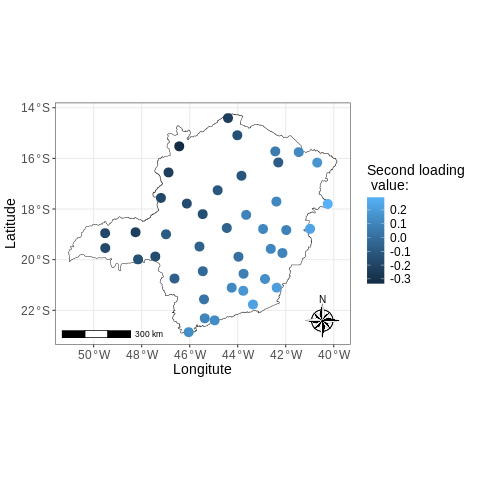

In [ ]:
%%R
# Grafico de puntos Load2 (vectores propios) sobre mapa de estado 'MG'
ggplot(MapMG) +
  geom_sf(color = "black", fill = "white") +
  geom_point(data = DataMap, size = 4,
             aes(x = Lon, y = Lat, color = Load2)) +
  labs(x = "Longitute", y = "Latitude", color = "Second loading \n value:") +
  theme_bw() +
  annotation_scale() +
  annotation_north_arrow(location = "br", style = north_arrow_nautical) +
  theme(legend.title = element_text(size = 14),
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12),
        legend.text = element_text(size = 12))

In [ ]:
%%R
# Common components
mun <- "BURITIS"

x <- ts(X[,mun], start = c(2008, 1), end = c(2024, 12), frequency = 12)

#'data.frame':	408 obs. of  3 variables:
#$ Time : Date, format: "2008-01-31" "2008-02-29" ...
#$ Type : chr  "x1" "x1" "x1" "x1" ...
#$ Value: num  0.0805 -0.0484 -0.3707 0.016 -1.0796 ...
DataChi <- data.frame(Time = Data$Time, x1 = X[,mun], x2 = Chi[,mun]) %>%
  gather(key = "Type", value = "Value", 2:3)

head(DataChi)
# 2:3 A selection of columns. If empty, all variables are selected.
# x1: ts original (tranf. scaled)
# x2: Fac %*% t(Load), donde Fac = X %*% Load

        Time Type       Value
1 2008-01-31   x1  0.08047339
2 2008-02-29   x1 -0.04842282
3 2008-03-31   x1 -0.37066334
4 2008-04-30   x1  0.01602529
5 2008-05-31   x1 -1.07959250
6 2008-06-30   x1 -1.40183302


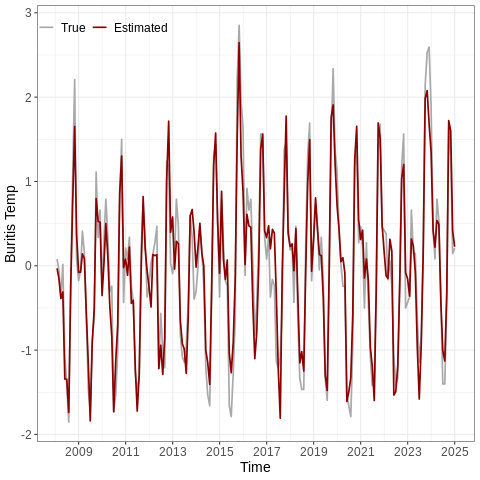

In [ ]:
%%R
# plot True (ts scaled) vs Estimated (x2: Chi = Fac %*% t(Load))
ggplot(DataChi, aes(x = Time, y = Value, colour = Type)) +
  geom_line(linewidth = 0.8) +
  scale_x_date(date_breaks = "2 years", date_labels = "%Y") +
  scale_colour_manual(values = c("darkgrey", "darkred"),
                      labels = c("True", "Estimated")) +
  labs(x = "Time", y = "Buritis Temp") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 12),
        legend.title = element_blank(),
        legend.text = element_text(size = 12),
        legend.position = "inside",
        legend.position.inside = c(.15, .95),
        legend.background = element_blank(),
        legend.key = element_blank(),
        legend.direction = "horizontal")

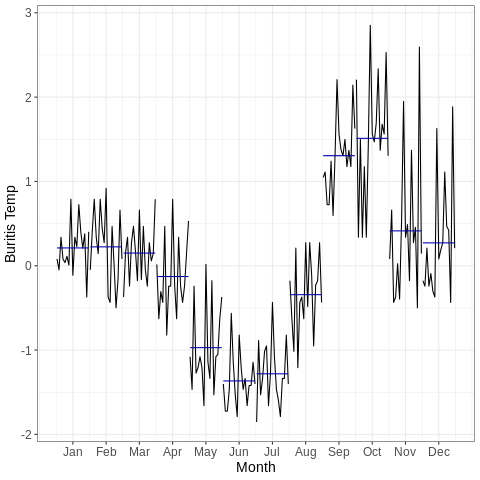

In [ ]:
%%R
# gráfico de Temp (scaled) subseries
ggsubseriesplot(x) +
  labs(y = "Buritis Temp") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

In [ ]:
%%R
mun <- "SERRA DOS AIMORES"

x <- ts(X[,mun], start = c(2008, 1), end = c(2024, 12), frequency = 12)

DataChi <- data.frame(Time = Data$Time, x1 = X[,mun], x2 = Chi[,mun]) %>%
  gather(key = "Type", value = "Value", 2:3)
head(DataChi)

        Time Type      Value
1 2008-01-31   x1  0.6135994
2 2008-02-29   x1  1.0195632
3 2008-03-31   x1  0.7150904
4 2008-04-30   x1  0.9180722
5 2008-05-31   x1 -0.7565283
6 2008-06-30   x1 -1.2639831


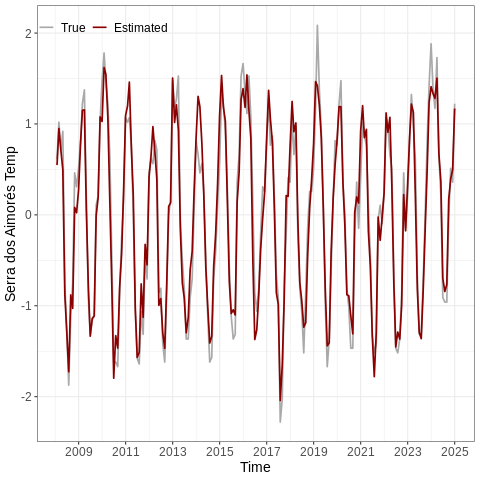

In [ ]:
%%R
# plot True (ts scaled) vs Estimated (x2: Chi = Fac %*% t(Load))
ggplot(DataChi, aes(x = Time, y = Value, colour = Type)) +
  geom_line(linewidth = 0.8) +
  scale_x_date(date_breaks = "2 years", date_labels = "%Y") +
  scale_colour_manual(values = c("darkgrey", "darkred"),
                      labels = c("True", "Estimated")) +
  labs(x = "Time", y = "Serra dos Aimorés Temp") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 12),
        legend.title = element_blank(),
        legend.text = element_text(size = 12),
        legend.position = "inside",
        legend.position.inside = c(.15, .95),
        legend.background = element_blank(),
        legend.key = element_blank(),
        legend.direction = "horizontal")

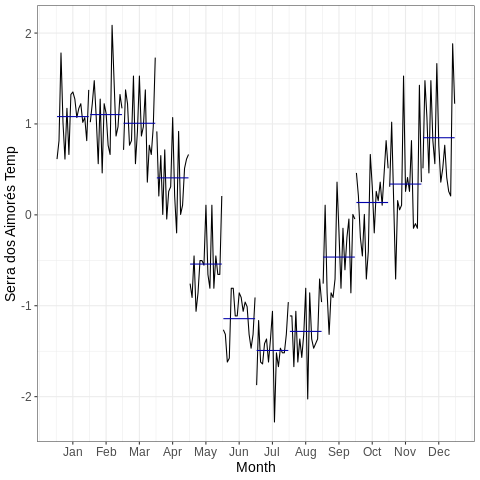

In [ ]:
%%R
ggsubseriesplot(x) +
  labs(y = "Serra dos Aimorés Temp") +
  theme_bw() +
  theme(axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))